# Importing Required Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

sns.set()

import warnings
warnings.filterwarnings('ignore')

# Reading loan_status

In [2]:
loan_status_df_backup = pd.read_csv('Columns/loan_status.csv')
loan_status_df = pd.DataFrame(loan_status_df_backup['loan_status'])

### Unique Values

In [3]:
loan_status_df['loan_status'].unique()

array(['Current', 'Fully Paid', 'Late (31-120 days)', 'In Grace Period',
       'Charged Off', 'Late (16-30 days)', 'Default',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

### Missing Values

In [4]:
loan_status_df['loan_status'].isna().sum()

0

### Creating Dummies

In [5]:
loan_status_df_dummies = pd.DataFrame(np.where(
    (loan_status_df['loan_status'] == 'Current') | (loan_status_df['loan_status'] == 'Fully Paid') | (loan_status_df['loan_status'] == 'Late (16-30 days)') | (loan_status_df['loan_status'] == 'In Grace Period') | (loan_status_df['loan_status'] == 'Does not meet the credit policy. Status:Fully Paid'), 1, 0), 
                                      columns=['loan_status:Not_Default'])

In [6]:
loan_status_df_dummies['loan_status:Not_Default'].unique()

array([1, 0], dtype=int64)

# Splitting into train test sets

In [7]:
train_indices, test_indices, train_targets, test_targets = train_test_split(loan_status_df_dummies.index, loan_status_df_dummies['loan_status:Not_Default'], random_state=42, test_size=0.2)

In [8]:
print("Trainig Indices shape - ", train_indices.shape)
print("Trainig Targets(loan_status:Not_Default) shape - ", train_targets.shape)
print("Testing Indices shape - ", test_indices.shape)
print("Testing Targets(loan_status:Not_Default) shape - ", test_targets.shape)

Trainig Indices shape -  (1808534,)
Trainig Targets(loan_status:Not_Default) shape -  (1808534,)
Testing Indices shape -  (452134,)
Testing Targets(loan_status:Not_Default) shape -  (452134,)


# WOE Function

In [9]:
def woe_graph(df, feature_name, rot_angle=0):
    plt.rcParams['figure.figsize'] = 20, 7

    plt.plot(df, label='Weight of Evidence Curve', marker='o', linestyle='--', color='k')

    plt.title(str(feature_name)+' Categories vs WOE', size=24)
    plt.xlabel(str(feature_name)+' Categories', size=16)
    plt.ylabel('Weights of Evidence', size=16)
    
    plt.xticks(rotation=rot_angle)

    plt.legend()
    plt.show()

In [10]:
def calc_woe_df(df, train_targets, feature_name, rot_angle=0):
    
    woe_df = pd.DataFrame(
        columns=['n_obs', 
                 'proba_n_obs', 
                 'pos_obs', 
                 'proba_pos_obs', 
                 'neg_obs', 
                 'proba_neg_obs', 
                 'woe', 'woe_diff', 
                 'iv'], 
        index=df.columns
    )
    
    iv = 0
    for idx in woe_df.index:
        woe_df.at[idx, 'n_obs'] = df[idx].sum()
        woe_df.at[idx, 'proba_n_obs'] = df[idx].sum() / len(df)
        
        idx_not_default = train_targets[train_targets == 1].index
        idx_default = train_targets[train_targets == 0].index

        woe_df.at[idx, 'pos_obs'] = df.loc[idx_not_default][idx].sum()
        woe_df.at[idx, 'proba_pos_obs'] = df.loc[idx_not_default][idx].sum() / len(idx_not_default)

        woe_df.at[idx, 'neg_obs'] = df.loc[idx_default][idx].sum()
        woe_df.at[idx, 'proba_neg_obs'] = df.loc[idx_default][idx].sum() / len(idx_default)

        woe_df.at[idx, 'woe'] = np.log(woe_df.at[idx, 'proba_pos_obs'] / woe_df.at[idx, 'proba_neg_obs'])
        iv = iv + ((woe_df.at[idx, 'proba_pos_obs'] - woe_df.at[idx, 'proba_neg_obs']) * woe_df.at[idx, 'woe'])
    
    # woe_df.sort_values(by=['woe'], axis=0, inplace=True)
    woe_df['woe_diff'] = woe_df['woe'].diff(1)
    woe_df['iv'] = iv
    
    woe_graph(woe_df['woe'], feature_name, rot_angle)
    return woe_df

# Preprocessing of Discrete Variables

## Term

In [11]:
term_df_backup = pd.read_csv('Columns/term.csv')
term_df = term_df_backup[['term']]

#### Unique Values

In [12]:
term_df['term'].unique()

array([36, 60], dtype=int64)

#### Missing Values

In [13]:
term_df['term'].isna().sum()

0

#### term Column Dummies

In [14]:
term_df_dummies = pd.get_dummies(term_df['term'], prefix='term', prefix_sep=':')

#### term Column train test split

In [15]:
term_df_dummies_train, term_df_dummies_test = term_df_dummies.iloc[train_indices], term_df_dummies.iloc[test_indices]

#### term column WOE dataframe and plot

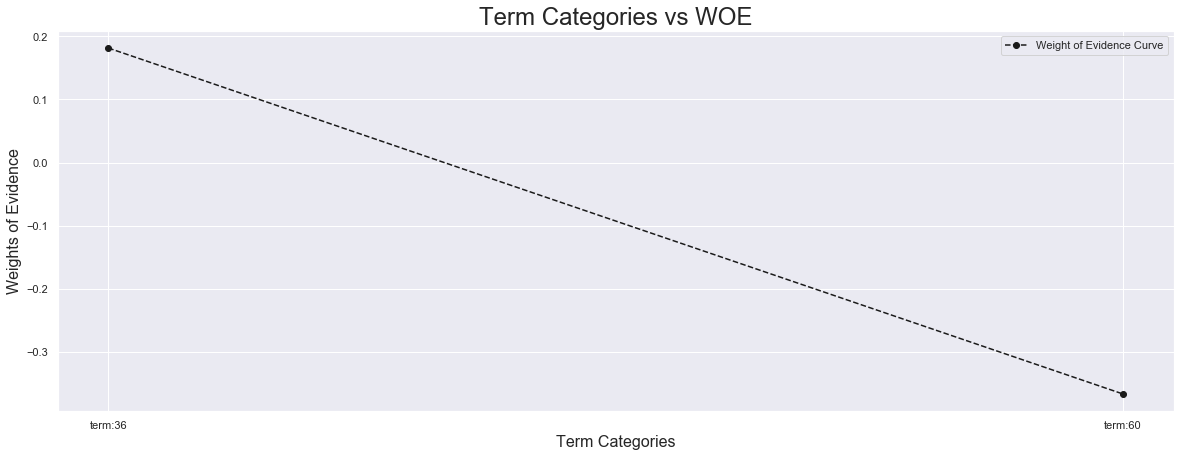

,n_obs,proba_n_obs,pos_obs,proba_pos_obs,neg_obs,proba_neg_obs,woe,woe_diff,iv
term:36,1288079,0.712223,1150206,0.727401,137873,0.606624,0.181568,NaN,0.066225
term:60,520455,0.287777,431049,0.272599,89406,0.393376,-0.366762,-0.548329,0.066225


In [16]:
calc_woe_df(term_df_dummies_train, train_targets, 'Term')

#### Training Features of term column

In [17]:
term_training_features_df = term_df_dummies_train[['term:60']]
term_training_features_df['term:36'] = term_df_dummies_train['term:36']

#### Testing Features of term column

In [18]:
term_testing_features_df = term_df_dummies_test[['term:60']]
term_testing_features_df['term:36'] = term_df_dummies_test['term:36']

#### Adding term feature to the set of training and testing features

In [19]:
training_features_df = term_training_features_df
testing_features_df = term_testing_features_df

## Employment Length

In [20]:
emp_length_df_backup = pd.read_csv('Columns/emp_length.csv')
emp_length_df = emp_length_df_backup[['emp_length']]
emp_length_df = emp_length_df.astype('int')

#### Unique Values

In [21]:
emp_length_df['emp_length'].unique()

array([10,  6,  4,  0,  2,  9,  5,  3,  7,  1,  8], dtype=int64)

#### Missing Values

In [22]:
emp_length_df['emp_length'].isna().sum()

0

#### emp_length Column Dummies

In [23]:
emp_length_df_dummies = pd.get_dummies(emp_length_df['emp_length'], prefix='emp_length', prefix_sep=':')

#### emp_length Column train test split

In [24]:
emp_length_df_dummies_train, emp_length_df_dummies_test = emp_length_df_dummies.iloc[train_indices], emp_length_df_dummies.iloc[test_indices]

#### emp_length column WOE dataframe and plot

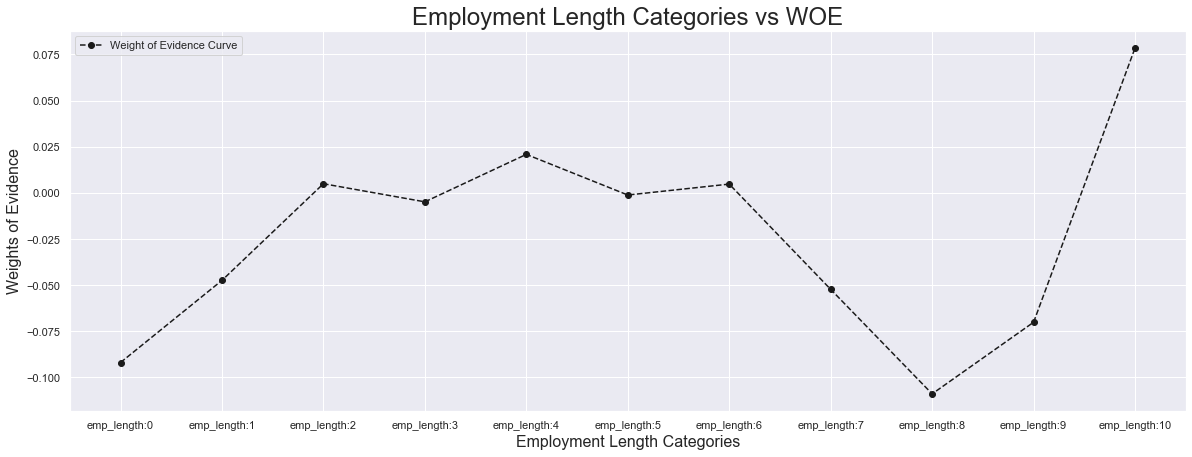

,n_obs,proba_n_obs,pos_obs,proba_pos_obs,neg_obs,proba_neg_obs,woe,woe_diff,iv
emp_length:0,269712,0.149133,232997,0.147349,36715,0.161542,-0.0919556,NaN,0.004262
emp_length:1,118648,0.0656045,103108,0.0652064,15540,0.0683741,-0.0474361,0.0445195,0.004262
emp_length:2,163041,0.0901509,142640,0.0902068,20401,0.0897619,0.00494428,0.0523804,0.004262
emp_length:3,144605,0.079957,126355,0.079908,18250,0.0802978,-0.00486545,-0.00980973,0.004262
emp_length:4,109209,0.0603854,95733,0.0605424,13476,0.0592928,0.020857,0.0257224,0.004262
emp_length:5,111790,0.0618125,97727,0.0618034,14063,0.0618755,-0.00116513,-0.0220221,0.004262
emp_length:6,82062,0.0453749,71792,0.0454019,10270,0.0451868,0.00475025,0.00591538,0.004262
emp_length:7,74021,0.0409287,64285,0.0406544,9736,0.0428372,-0.0522998,-0.0570501,0.004262
emp_length:8,73442,0.0406086,63297,0.0400296,10145,0.0446368,-0.108939,-0.056639,0.004262
emp_length:9,63573,0.0351517,55081,0.0348337,8492,0.0373638,-0.0701155,0.0388233,0.004262


In [25]:
calc_woe_df(emp_length_df_dummies_train, train_targets, 'Employment Length')

#### Training Features of emp_length column

In [26]:
emp_length_training_features_df = emp_length_df_dummies_train[['emp_length:0']]
emp_length_training_features_df['emp_length:1'] = emp_length_df_dummies_train['emp_length:1']
emp_length_training_features_df['emp_length:2_6'] = np.where( ((emp_length_df_dummies_train['emp_length:2'] == 1) | (emp_length_df_dummies_train['emp_length:3'] == 1) | (emp_length_df_dummies_train['emp_length:4'] == 1) | (emp_length_df_dummies_train['emp_length:5'] == 1) | (emp_length_df_dummies_train['emp_length:6'] == 1)), 1, 0)
emp_length_training_features_df['emp_length:7'] = emp_length_df_dummies_train['emp_length:7']
emp_length_training_features_df['emp_length:8'] = emp_length_df_dummies_train[['emp_length:8']]
emp_length_training_features_df['emp_length:9'] = emp_length_df_dummies_train['emp_length:9']
emp_length_training_features_df['emp_length:10'] = emp_length_df_dummies_train['emp_length:10']

#### Testing Features of emp_length column

In [27]:
emp_length_testing_features_df = emp_length_df_dummies_test[['emp_length:0']]
emp_length_testing_features_df['emp_length:1'] = emp_length_df_dummies_test['emp_length:1']
emp_length_testing_features_df['emp_length:2_6'] = np.where( ((emp_length_df_dummies_test['emp_length:2'] == 1) | (emp_length_df_dummies_test['emp_length:3'] == 1) | (emp_length_df_dummies_test['emp_length:4'] == 1) | (emp_length_df_dummies_test['emp_length:5'] == 1) | (emp_length_df_dummies_test['emp_length:6'] == 1)), 1, 0)
emp_length_testing_features_df['emp_length:7'] = emp_length_df_dummies_test['emp_length:7']
emp_length_testing_features_df['emp_length:8'] = emp_length_df_dummies_test[['emp_length:8']]
emp_length_testing_features_df['emp_length:9'] = emp_length_df_dummies_test['emp_length:9']
emp_length_testing_features_df['emp_length:10'] = emp_length_df_dummies_test['emp_length:10']

#### Adding term feature to the set of training and testing features

In [28]:
training_features_df = pd.concat((training_features_df, emp_length_training_features_df), axis=1)
testing_features_df = pd.concat((testing_features_df, emp_length_testing_features_df), axis=1)

## Months Since Issue Date

In [29]:
mths_issue_d_df_backup = pd.read_csv('Columns/mths_issue_d.csv')
mths_issue_d_df = mths_issue_d_df_backup[['mths_issue_d']]

#### Unique Values

In [30]:
mths_issue_d_df['mths_issue_d'].unique()

array([ 13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  37,  38,  39,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  34,  35,  36,
        28,  29,  30,  31,  32,  33,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  61,  62,  63,  64,  65,  66,  67,  68,  69,
        70,  71,  72,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106,
       107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
       120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,
       133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145,
       146, 147, 148, 149, 150, 151,  25,  26,  27], dtype=int64)

#### Missing Values

In [31]:
mths_issue_d_df['mths_issue_d'].isna().sum()

0

#### mths_issue_d Column train test split

In [32]:
mths_issue_d_df_train, mths_issue_d_df_test = mths_issue_d_df.iloc[train_indices], mths_issue_d_df.iloc[test_indices]

#### Fine Classing mths_issue_d into Categories and creating dummies

In [33]:
mths_issue_d_df_dummies = pd.get_dummies(pd.cut(mths_issue_d_df['mths_issue_d'], 50), prefix='mths_issue_d', prefix_sep=':')

#### mths_issue_d dummies Column train test split

In [34]:
mths_issue_d_df_dummies_train, mths_issue_d_df_dummies_test = mths_issue_d_df_dummies.iloc[train_indices], mths_issue_d_df_dummies.iloc[test_indices]

#### mths_issue_d column WOE dataframe and plot

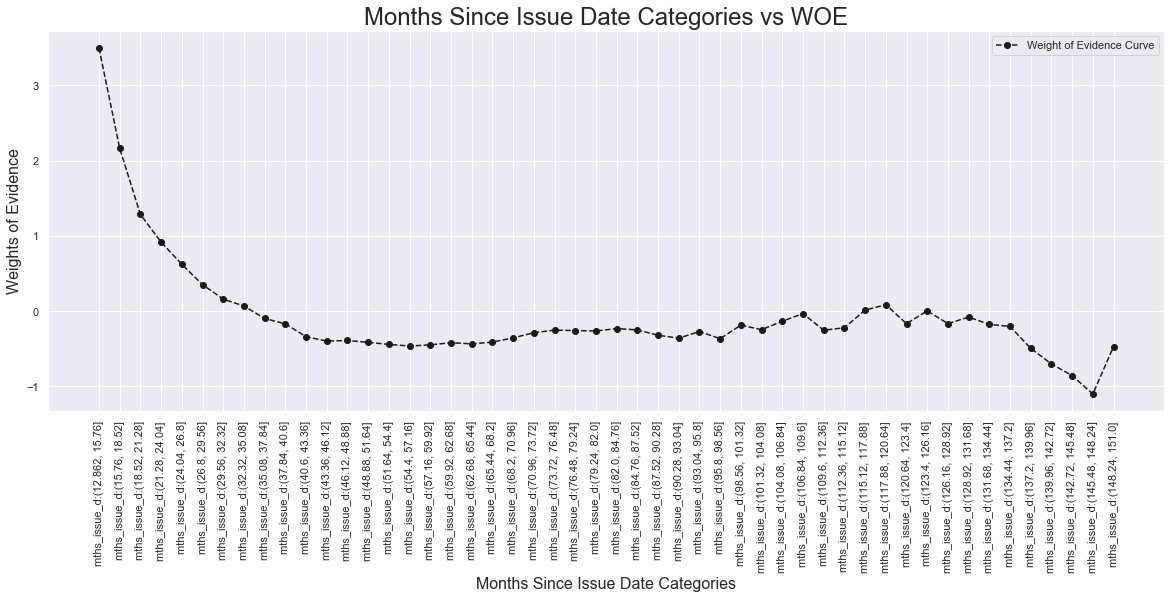

,n_obs,proba_n_obs,pos_obs,proba_pos_obs,neg_obs,proba_neg_obs,woe,woe_diff,iv
"mths_issue_d:(12.862, 15.76]",102884,0.0568881,102437,0.0647821,447,0.00196675,3.49465,NaN,0.540132
"mths_issue_d:(15.76, 18.52]",102605,0.0567338,100935,0.0638322,1670,0.0073478,2.16186,-1.33279,0.540132
"mths_issue_d:(18.52, 21.28]",104563,0.0578164,100561,0.0635957,4002,0.0176083,1.28417,-0.877683,0.540132
"mths_issue_d:(21.28, 24.04]",86368,0.0477558,81677,0.0516533,4691,0.0206398,0.917331,-0.366844,0.540132
"mths_issue_d:(24.04, 26.8]",64324,0.0355669,59718,0.0377662,4606,0.0202658,0.622478,-0.294853,0.540132
"mths_issue_d:(26.8, 29.56]",97239,0.0537668,88311,0.0558487,8928,0.0392821,0.351876,-0.270601,0.540132
"mths_issue_d:(29.56, 32.32]",92057,0.0509014,82008,0.0518626,10049,0.0442144,0.159548,-0.192329,0.540132
"mths_issue_d:(32.32, 35.08]",75549,0.0417736,66605,0.0421216,8944,0.0393525,0.068001,-0.0915469,0.540132
"mths_issue_d:(35.08, 37.84]",54361,0.030058,46928,0.0296777,7433,0.0327043,-0.0971108,-0.165112,0.540132
"mths_issue_d:(37.84, 40.6]",76286,0.0421811,65196,0.0412305,11090,0.0487947,-0.168441,-0.0713307,0.540132


In [36]:
calc_woe_df(mths_issue_d_df_dummies_train, train_targets, 'Months Since Issue Date', 90)

#### Training Features of mths_issue_d column

In [37]:
mths_issue_d_training_features_df = pd.DataFrame(columns = [
    'mths_issue_d:12_16',
    'mths_issue_d:16_19',
    'mths_issue_d:19_22',
    'mths_issue_d:22_24',
    'mths_issue_d:24_26',
    'mths_issue_d:26_30',
    'mths_issue_d:30_35',
    'mths_issue_d:35_40',
    'mths_issue_d:40_70',
    'mths_issue_d:70_93',
    'mths_issue_d:93+'
], index = train_indices)

mths_issue_d_training_features_df['mths_issue_d:12_16'] = np.where(( (mths_issue_d_df_train['mths_issue_d']>=12) & (mths_issue_d_df_train['mths_issue_d']<16) ), 1, 0)
mths_issue_d_training_features_df['mths_issue_d:16_19'] = np.where(( (mths_issue_d_df_train['mths_issue_d']>=16) & (mths_issue_d_df_train['mths_issue_d']<19) ), 1, 0)
mths_issue_d_training_features_df['mths_issue_d:19_22'] = np.where(( (mths_issue_d_df_train['mths_issue_d']>=19) & (mths_issue_d_df_train['mths_issue_d']<22) ), 1, 0)
mths_issue_d_training_features_df['mths_issue_d:22_24'] = np.where(( (mths_issue_d_df_train['mths_issue_d']>=22) & (mths_issue_d_df_train['mths_issue_d']<24) ), 1, 0)
mths_issue_d_training_features_df['mths_issue_d:24_26'] = np.where(( (mths_issue_d_df_train['mths_issue_d']>=24) & (mths_issue_d_df_train['mths_issue_d']<26) ), 1, 0)
mths_issue_d_training_features_df['mths_issue_d:26_30'] = np.where(( (mths_issue_d_df_train['mths_issue_d']>=26) & (mths_issue_d_df_train['mths_issue_d']<30) ), 1, 0)
mths_issue_d_training_features_df['mths_issue_d:30_35'] = np.where(( (mths_issue_d_df_train['mths_issue_d']>=30) & (mths_issue_d_df_train['mths_issue_d']<35) ), 1, 0)
mths_issue_d_training_features_df['mths_issue_d:35_40'] = np.where(( (mths_issue_d_df_train['mths_issue_d']>=35) & (mths_issue_d_df_train['mths_issue_d']<40) ), 1, 0)
mths_issue_d_training_features_df['mths_issue_d:40_70'] = np.where(( (mths_issue_d_df_train['mths_issue_d']>=40) & (mths_issue_d_df_train['mths_issue_d']<70) ), 1, 0)
mths_issue_d_training_features_df['mths_issue_d:70_93'] = np.where(( (mths_issue_d_df_train['mths_issue_d']>=70) & (mths_issue_d_df_train['mths_issue_d']<93) ), 1, 0)
mths_issue_d_training_features_df['mths_issue_d:93+'] = np.where(( (mths_issue_d_df_train['mths_issue_d']>=93) ), 1, 0)

#### Testing Features of mths_issue_d column

In [38]:
mths_issue_d_testing_features_df = pd.DataFrame(columns = [
    'mths_issue_d:12_16',
    'mths_issue_d:16_19',
    'mths_issue_d:19_22',
    'mths_issue_d:22_24',
    'mths_issue_d:24_26',
    'mths_issue_d:26_30',
    'mths_issue_d:30_35',
    'mths_issue_d:35_40',
    'mths_issue_d:40_70',
    'mths_issue_d:70_93',
    'mths_issue_d:93+'
], index = test_indices)

mths_issue_d_testing_features_df['mths_issue_d:12_16'] = np.where(( (mths_issue_d_df_test['mths_issue_d']>=12) & (mths_issue_d_df_test['mths_issue_d']<16) ), 1, 0)
mths_issue_d_testing_features_df['mths_issue_d:16_19'] = np.where(( (mths_issue_d_df_test['mths_issue_d']>=16) & (mths_issue_d_df_test['mths_issue_d']<19) ), 1, 0)
mths_issue_d_testing_features_df['mths_issue_d:19_22'] = np.where(( (mths_issue_d_df_test['mths_issue_d']>=19) & (mths_issue_d_df_test['mths_issue_d']<22) ), 1, 0)
mths_issue_d_testing_features_df['mths_issue_d:22_24'] = np.where(( (mths_issue_d_df_test['mths_issue_d']>=22) & (mths_issue_d_df_test['mths_issue_d']<24) ), 1, 0)
mths_issue_d_testing_features_df['mths_issue_d:24_26'] = np.where(( (mths_issue_d_df_test['mths_issue_d']>=24) & (mths_issue_d_df_test['mths_issue_d']<26) ), 1, 0)
mths_issue_d_testing_features_df['mths_issue_d:26_30'] = np.where(( (mths_issue_d_df_test['mths_issue_d']>=26) & (mths_issue_d_df_test['mths_issue_d']<30) ), 1, 0)
mths_issue_d_testing_features_df['mths_issue_d:30_35'] = np.where(( (mths_issue_d_df_test['mths_issue_d']>=30) & (mths_issue_d_df_test['mths_issue_d']<35) ), 1, 0)
mths_issue_d_testing_features_df['mths_issue_d:35_40'] = np.where(( (mths_issue_d_df_test['mths_issue_d']>=35) & (mths_issue_d_df_test['mths_issue_d']<40) ), 1, 0)
mths_issue_d_testing_features_df['mths_issue_d:40_70'] = np.where(( (mths_issue_d_df_test['mths_issue_d']>=40) & (mths_issue_d_df_test['mths_issue_d']<70) ), 1, 0)
mths_issue_d_testing_features_df['mths_issue_d:70_93'] = np.where(( (mths_issue_d_df_test['mths_issue_d']>=70) & (mths_issue_d_df_test['mths_issue_d']<93) ), 1, 0)
mths_issue_d_testing_features_df['mths_issue_d:93+'] = np.where(( (mths_issue_d_df_test['mths_issue_d']>=93) ), 1, 0)

#### Adding mths_issue_d feature to the set of training and testing features

In [39]:
training_features_df = pd.concat((training_features_df, mths_issue_d_training_features_df), axis=1)
testing_features_df = pd.concat((testing_features_df, mths_issue_d_testing_features_df), axis=1)

## Interest Rate

In [40]:
int_rate_df_backup = pd.read_csv('Columns/int_rate.csv')
int_rate_df = int_rate_df_backup[['int_rate']]

#### Range of  Values

In [41]:
int_rate_df['int_rate'].describe()

count    2.260668e+06
mean     1.309291e+01
std      4.832114e+00
min      5.310000e+00
25%      9.490000e+00
50%      1.262000e+01
75%      1.599000e+01
max      3.099000e+01
Name: int_rate, dtype: float64

#### Missing Values

In [42]:
int_rate_df['int_rate'].isna().sum()

0

#### int_rate Column train test split

In [43]:
int_rate_df_train, int_rate_df_test = int_rate_df.iloc[train_indices], int_rate_df.iloc[test_indices]

#### Fine Classing int_rate into Categories and creating dummies

In [44]:
int_rate_df_dummies = pd.get_dummies(pd.cut(int_rate_df['int_rate'], 13), prefix='int_rate', prefix_sep=':')

#### int_rate dummies Column train test split

In [45]:
int_rate_df_dummies_train, int_rate_df_dummies_test = int_rate_df_dummies.iloc[train_indices], int_rate_df_dummies.iloc[test_indices]

#### int_rate column WOE dataframe and plot

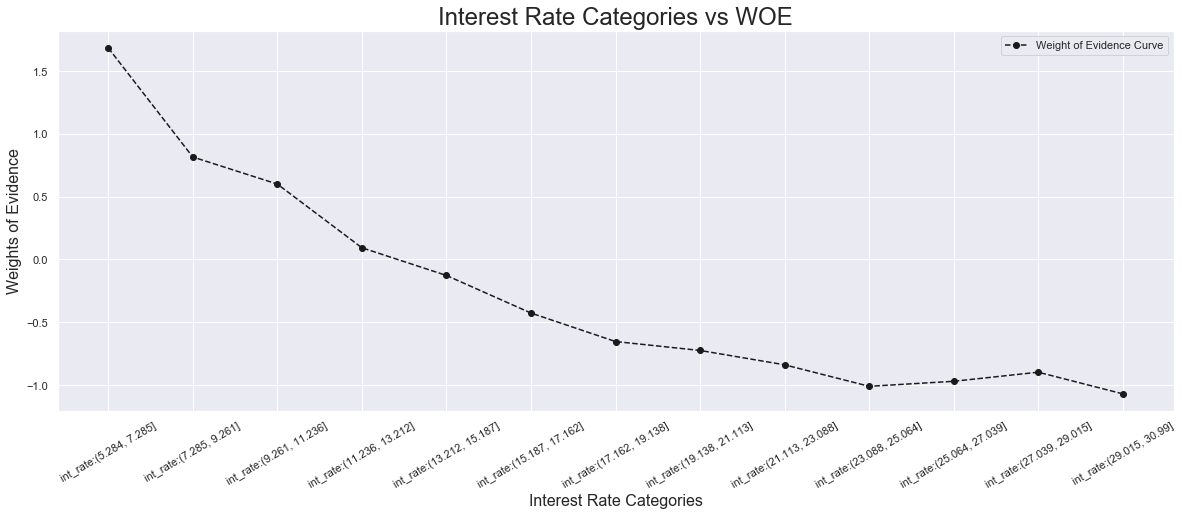

,n_obs,proba_n_obs,pos_obs,proba_pos_obs,neg_obs,proba_neg_obs,woe,woe_diff,iv
"int_rate:(5.284, 7.285]",185304,0.102461,180488,0.114142,4816,0.0211898,1.68392,NaN,0.437083
"int_rate:(7.285, 9.261]",237961,0.131577,223733,0.141491,14228,0.0626015,0.815446,-0.868479,0.437083
"int_rate:(9.261, 11.236]",266666,0.147449,247169,0.156312,19497,0.0857844,0.600016,-0.21543,0.437083
"int_rate:(11.236, 13.212]",310898,0.171906,274894,0.173845,36004,0.158413,0.0929597,-0.507056,0.437083
"int_rate:(13.212, 15.187]",294371,0.162768,253054,0.160034,41317,0.18179,-0.127467,-0.220427,0.437083
"int_rate:(15.187, 17.162]",184765,0.102163,151415,0.0957562,33350,0.146736,-0.426829,-0.299362,0.437083
"int_rate:(17.162, 19.138]",138497,0.0765797,108514,0.0686252,29983,0.131922,-0.653547,-0.226718,0.437083
"int_rate:(19.138, 21.113]",72803,0.0402553,56148,0.0355085,16655,0.07328,-0.724515,-0.0709681,0.437083
"int_rate:(21.113, 23.088]",45536,0.0251784,34173,0.0216113,11363,0.0499958,-0.838722,-0.114207,0.437083
"int_rate:(23.088, 25.064]",32401,0.0179156,23233,0.0146928,9168,0.0403381,-1.00994,-0.171219,0.437083


In [46]:
calc_woe_df(int_rate_df_dummies_train, train_targets, 'Interest Rate', 30)

#### Training Features of int_rate column

In [47]:
int_rate_training_features_df = pd.DataFrame(columns = [
    'int_rate:5_7',
    'int_rate:7_11',
    'int_rate:11_15',
    'int_rate:15_19',
    'int_rate:19_23',
    'int_rate:23+'
], index=train_indices)

int_rate_training_features_df['int_rate:5_7'] = np.where(( (int_rate_df_train['int_rate']>=5) & (int_rate_df_train['int_rate']<7) ), 1, 0)
int_rate_training_features_df['int_rate:7_11'] = np.where(( (int_rate_df_train['int_rate']>=7) & (int_rate_df_train['int_rate']<11) ), 1, 0)
int_rate_training_features_df['int_rate:11_15'] = np.where(( (int_rate_df_train['int_rate']>=11) & (int_rate_df_train['int_rate']<15) ), 1, 0)
int_rate_training_features_df['int_rate:15_19'] = np.where(( (int_rate_df_train['int_rate']>=15) & (int_rate_df_train['int_rate']<19) ), 1, 0)
int_rate_training_features_df['int_rate:19_23'] = np.where(( (int_rate_df_train['int_rate']>=19) & (int_rate_df_train['int_rate']<23) ), 1, 0)
int_rate_training_features_df['int_rate:23+'] = np.where(( (int_rate_df_train['int_rate']>=23) ), 1, 0)

#### Testing Features of int_rate column

In [48]:
int_rate_testing_features_df = pd.DataFrame(columns = [
    'int_rate:5_7',
    'int_rate:7_11',
    'int_rate:11_15',
    'int_rate:15_19',
    'int_rate:19_23',
    'int_rate:23+'
], index=test_indices)

int_rate_testing_features_df['int_rate:5_7'] = np.where(( (int_rate_df_test['int_rate']>=5) & (int_rate_df_test['int_rate']<7) ), 1, 0)
int_rate_testing_features_df['int_rate:7_11'] = np.where(( (int_rate_df_test['int_rate']>=7) & (int_rate_df_test['int_rate']<11) ), 1, 0)
int_rate_testing_features_df['int_rate:11_15'] = np.where(( (int_rate_df_test['int_rate']>=11) & (int_rate_df_test['int_rate']<15) ), 1, 0)
int_rate_testing_features_df['int_rate:15_19'] = np.where(( (int_rate_df_test['int_rate']>=15) & (int_rate_df_test['int_rate']<19) ), 1, 0)
int_rate_testing_features_df['int_rate:19_23'] = np.where(( (int_rate_df_test['int_rate']>=19) & (int_rate_df_test['int_rate']<23) ), 1, 0)
int_rate_testing_features_df['int_rate:23+'] = np.where(( (int_rate_df_test['int_rate']>=23) ), 1, 0)

#### Adding int_rate feature to the set of training and testing features

In [49]:
training_features_df = pd.concat((training_features_df, int_rate_training_features_df), axis=1)
testing_features_df = pd.concat((testing_features_df, int_rate_testing_features_df), axis=1)

## Funded Amount

In [50]:
funded_amnt_df_backup = pd.read_csv('Columns/funded_amnt.csv')
funded_amnt_df = funded_amnt_df_backup[['funded_amnt']]

#### Range of  Values

In [51]:
funded_amnt_df['funded_amnt'].describe()

count    2.260668e+06
mean     1.504166e+04
std      9.188413e+03
min      5.000000e+02
25%      8.000000e+03
50%      1.287500e+04
75%      2.000000e+04
max      4.000000e+04
Name: funded_amnt, dtype: float64

#### Missing Values

In [52]:
funded_amnt_df['funded_amnt'].isna().sum()

0

#### funded_amnt Column train test split

In [53]:
funded_amnt_df_train, funded_amnt_df_test = funded_amnt_df.iloc[train_indices], funded_amnt_df.iloc[test_indices]

#### Fine Classing funded_amnt into Categories and creating dummies

In [54]:
funded_amnt_df_dummies = pd.get_dummies(pd.cut(funded_amnt_df['funded_amnt'], 20), prefix='funded_amnt', prefix_sep=':')

#### funded_amnt dummies Column train test split

In [55]:
funded_amnt_df_dummies_train, funded_amnt_df_dummies_test = funded_amnt_df_dummies.iloc[train_indices], funded_amnt_df_dummies.iloc[test_indices]

#### funded_amnt column WOE dataframe and plot

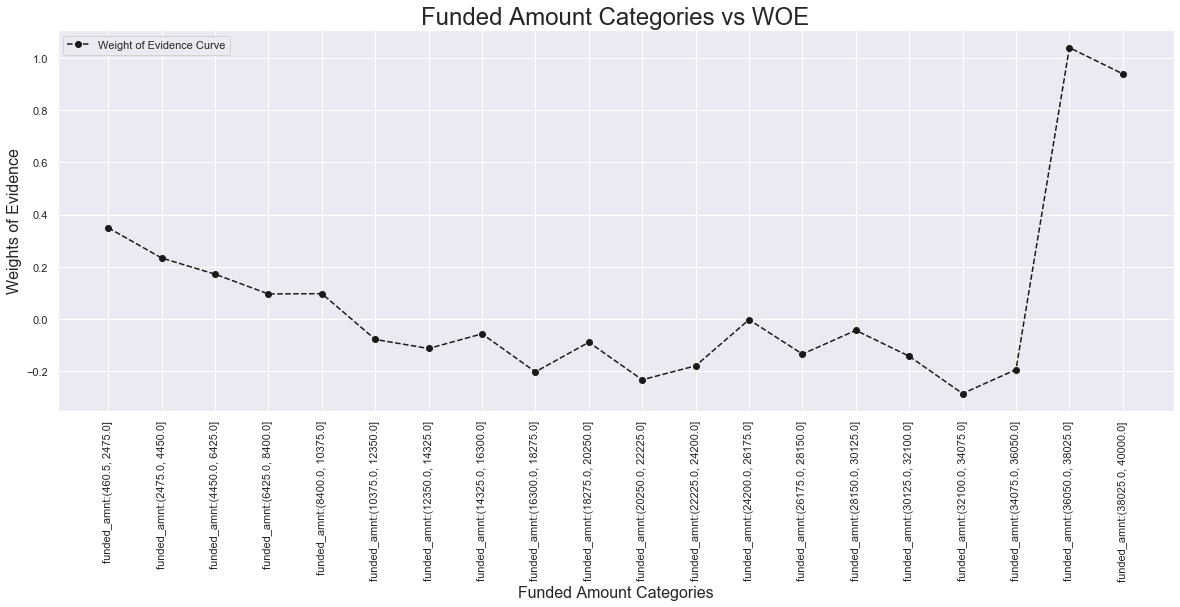

,n_obs,proba_n_obs,pos_obs,proba_pos_obs,neg_obs,proba_neg_obs,woe,woe_diff,iv
"funded_amnt:(460.5, 2475.0]",45914,0.0253874,41688,0.0263639,4226,0.0185939,0.349162,NaN,0.031223
"funded_amnt:(2475.0, 4450.0]",103965,0.0574858,93339,0.0590284,10626,0.0467531,0.233138,-0.116023,0.031223
"funded_amnt:(4450.0, 6425.0]",190642,0.105412,170046,0.107539,20596,0.0906199,0.171176,-0.0619621,0.031223
"funded_amnt:(6425.0, 8400.0]",159909,0.0884191,141427,0.0894397,18482,0.0813186,0.0951906,-0.0759857,0.031223
"funded_amnt:(8400.0, 10375.0]",224563,0.124169,198636,0.125619,25927,0.114076,0.0963933,0.00120271,0.031223
"funded_amnt:(10375.0, 12350.0]",163355,0.0903245,141358,0.0893961,21997,0.0967841,-0.0794062,-0.1758,0.031223
"funded_amnt:(12350.0, 14325.0]",82259,0.0454838,70845,0.044803,11414,0.0502202,-0.114142,-0.0347359,0.031223
"funded_amnt:(14325.0, 16300.0]",190211,0.105174,165069,0.104391,25142,0.110622,-0.057972,0.0561701,0.031223
"funded_amnt:(16300.0, 18275.0]",82396,0.0455596,70050,0.0443003,12346,0.0543209,-0.203919,-0.145947,0.031223
"funded_amnt:(18275.0, 20250.0]",138664,0.076672,119816,0.0757727,18848,0.0829289,-0.0902454,0.113673,0.031223


In [56]:
calc_woe_df(funded_amnt_df_dummies_train, train_targets, 'Funded Amount', 90)

#### Training Features of funded_amnt column

In [57]:
funded_amnt_training_features_df = pd.DataFrame(columns = [
    'funded_amnt:460_2475',
    'funded_amnt:2475_4450',
    'funded_amnt:4450_10375',
    'funded_amnt:10375_16300',
    'funded_amnt:16300_36050',
    'funded_amnt:36050+'
], index=train_indices)

funded_amnt_training_features_df['funded_amnt:460_2475'] = np.where(( (funded_amnt_df_train['funded_amnt']>=460) & (funded_amnt_df_train['funded_amnt']<2475) ), 1, 0)
funded_amnt_training_features_df['funded_amnt:2475_4450'] = np.where(( (funded_amnt_df_train['funded_amnt']>=2475) & (funded_amnt_df_train['funded_amnt']<4450) ), 1, 0)
funded_amnt_training_features_df['funded_amnt:4450_10375'] = np.where(( (funded_amnt_df_train['funded_amnt']>=4450) & (funded_amnt_df_train['funded_amnt']<10375) ), 1, 0)
funded_amnt_training_features_df['funded_amnt:10375_16300'] = np.where(( (funded_amnt_df_train['funded_amnt']>=10375) & (funded_amnt_df_train['funded_amnt']<16300) ), 1, 0)
funded_amnt_training_features_df['funded_amnt:16300_36050'] = np.where(( (funded_amnt_df_train['funded_amnt']>=16300) & (funded_amnt_df_train['funded_amnt']<36050) ), 1, 0)
funded_amnt_training_features_df['funded_amnt:36050+'] = np.where(( (funded_amnt_df_train['funded_amnt']>=36050) ), 1, 0)

#### Testing Features of funded_amnt column

In [58]:
funded_amnt_testing_features_df = pd.DataFrame(columns = [
    'funded_amnt:460_2475',
    'funded_amnt:2475_4450',
    'funded_amnt:4450_10375',
    'funded_amnt:10375_16300',
    'funded_amnt:16300_36050',
    'funded_amnt:36050+'
], index=test_indices)

funded_amnt_testing_features_df['funded_amnt:460_2475'] = np.where(( (funded_amnt_df_test['funded_amnt']>=460) & (funded_amnt_df_test['funded_amnt']<2475) ), 1, 0)
funded_amnt_testing_features_df['funded_amnt:2475_4450'] = np.where(( (funded_amnt_df_test['funded_amnt']>=2475) & (funded_amnt_df_test['funded_amnt']<4450) ), 1, 0)
funded_amnt_testing_features_df['funded_amnt:4450_10375'] = np.where(( (funded_amnt_df_test['funded_amnt']>=4450) & (funded_amnt_df_test['funded_amnt']<10375) ), 1, 0)
funded_amnt_testing_features_df['funded_amnt:10375_16300'] = np.where(( (funded_amnt_df_test['funded_amnt']>=10375) & (funded_amnt_df_test['funded_amnt']<16300) ), 1, 0)
funded_amnt_testing_features_df['funded_amnt:16300_36050'] = np.where(( (funded_amnt_df_test['funded_amnt']>=16300) & (funded_amnt_df_test['funded_amnt']<36050) ), 1, 0)
funded_amnt_testing_features_df['funded_amnt:36050+'] = np.where(( (funded_amnt_df_test['funded_amnt']>=36050) ), 1, 0)

#### Adding funded_amnt feature to the set of training and testing features

In [59]:
training_features_df = pd.concat((training_features_df, funded_amnt_training_features_df), axis=1)
testing_features_df = pd.concat((testing_features_df, funded_amnt_testing_features_df), axis=1)

## Annual Income

In [60]:
annual_inc_df_backup = pd.read_csv('Columns/annual_inc.csv')
annual_inc_df = annual_inc_df_backup[['annual_inc']]

#### Range of  Values

In [61]:
annual_inc_df['annual_inc'].describe()

count    2.260668e+06
mean     7.799243e+04
std      1.126961e+05
min      0.000000e+00
25%      4.600000e+04
50%      6.500000e+04
75%      9.300000e+04
max      1.100000e+08
Name: annual_inc, dtype: float64

#### Missing Values

In [62]:
annual_inc_df['annual_inc'].isna().sum()

0

#### annual_inc Column train test split

In [63]:
annual_inc_df_train, annual_inc_df_test = annual_inc_df.iloc[train_indices], annual_inc_df.iloc[test_indices]

#### Distribution of all Incomes

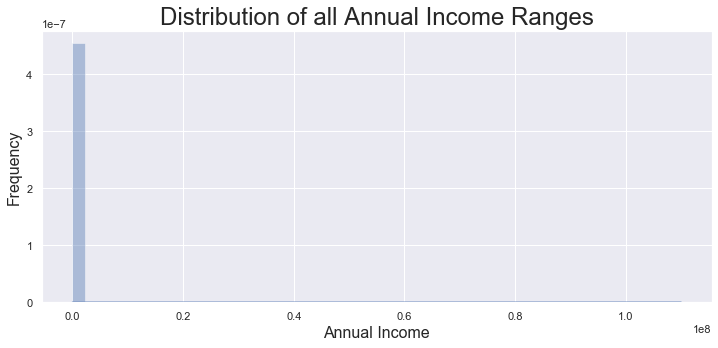

In [64]:
plt.figure(figsize = (12, 5))

sns.distplot(annual_inc_df_train['annual_inc'])

plt.title('Distribution of all Annual Income Ranges', size=24)
plt.xlabel('Annual Income', size=16)
plt.ylabel('Frequency', size=16)

plt.show()

#### Distribution of Inome below $\$140,000$ 

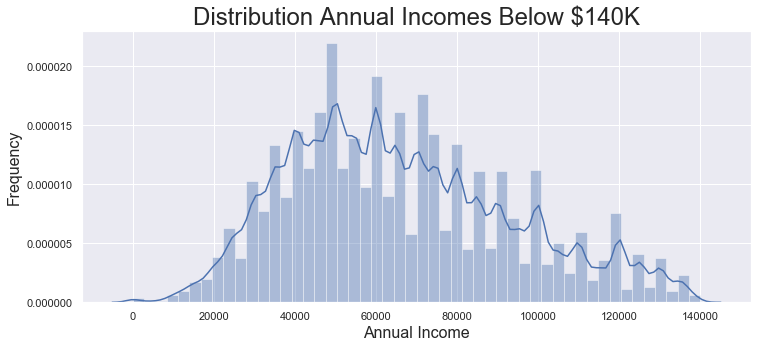

In [65]:
plt.figure(figsize = (12, 5))

sns.distplot(annual_inc_df_train[annual_inc_df_train['annual_inc']<140e+03])

plt.title('Distribution Annual Incomes Below $140K', size=24)
plt.xlabel('Annual Income', size=16)
plt.ylabel('Frequency', size=16)

plt.show()

#### anual_income thresholded

In [66]:
annual_inc_df_t = pd.DataFrame(np.where(annual_inc_df['annual_inc']<140e+03, annual_inc_df['annual_inc'], np.nan), columns=['annual_inc'])

#### Fine Classing thresholded annual_inc into Categories and creating dummies

In [67]:
annual_inc_df_dummies_t = pd.get_dummies(pd.cut(annual_inc_df_t['annual_inc'], 30), prefix='annual_inc', prefix_sep=':')

#### annual_inc dummies Column train test split

In [68]:
annual_inc_df_dummies_train, annual_inc_df_dummies_test = annual_inc_df_dummies_t.iloc[train_indices], annual_inc_df_dummies_t.iloc[test_indices]

#### annual_inc column WOE dataframe and plot

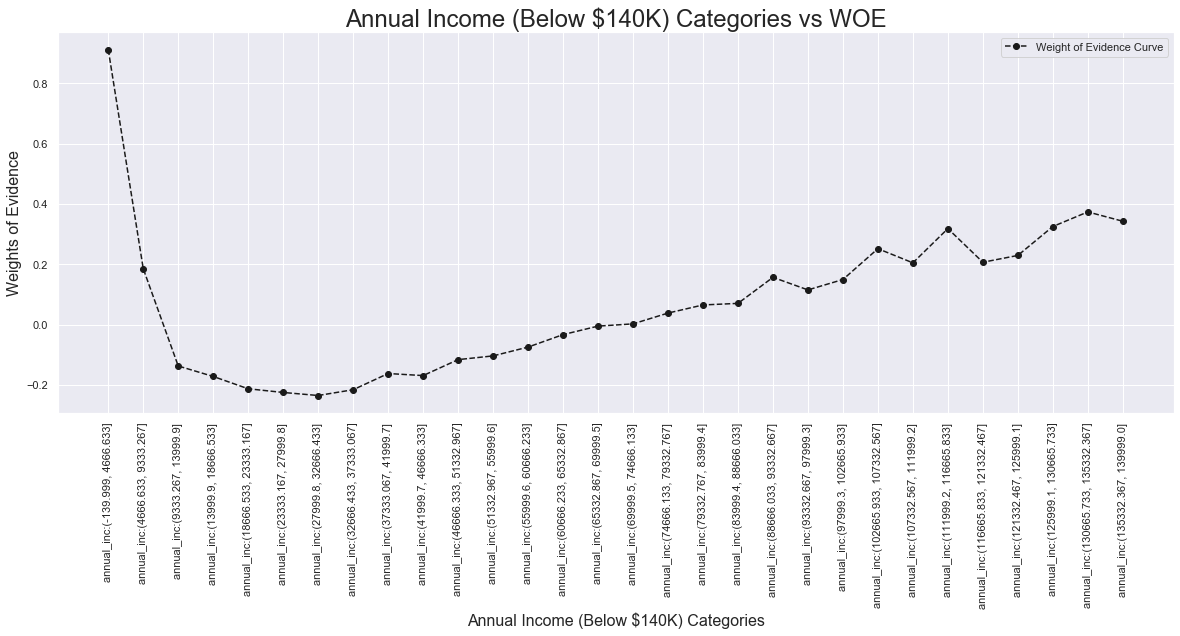

In [69]:
annual_inc_woe_df = calc_woe_df(annual_inc_df_dummies_train, train_targets, 'Annual Income (Below $140K)', 90)

In [70]:
annual_inc_woe_df.head(30)

,n_obs,proba_n_obs,pos_obs,proba_pos_obs,neg_obs,proba_neg_obs,woe,woe_diff,iv
"annual_inc:(-139.999, 4666.633]",1869,0.00103343,1767,0.00111747,102,0.000448788,0.91227,NaN,0.022219
"annual_inc:(4666.633, 9333.267]",1547,0.000855389,1382,0.000873989,165,0.00072598,0.185546,-0.726724,0.022219
"annual_inc:(9333.267, 13999.9]",6628,0.00366485,5690,0.00359841,938,0.00412709,-0.13708,-0.322626,0.022219
"annual_inc:(13999.9, 18666.533]",14170,0.00783508,12104,0.00765468,2066,0.00909015,-0.171874,-0.034794,0.022219
"annual_inc:(18666.533, 23333.167]",25695,0.0142076,21816,0.0137966,3879,0.0170671,-0.21273,-0.0408553,0.022219
"annual_inc:(23333.167, 27999.8]",41289,0.0228301,34991,0.0221286,6298,0.0277104,-0.224937,-0.0122075,0.022219
"annual_inc:(27999.8, 32666.433]",72710,0.0402038,61524,0.0389083,11186,0.049217,-0.235031,-0.0100944,0.022219
"annual_inc:(32666.433, 37333.067]",83993,0.0464426,71279,0.0450775,12714,0.0559401,-0.215898,0.0191337,0.022219
"annual_inc:(37333.067, 41999.7]",96812,0.0535306,82814,0.0523723,13998,0.0615895,-0.162113,0.0537847,0.022219
"annual_inc:(41999.7, 46666.333]",113641,0.062836,97113,0.0614151,16528,0.0727212,-0.168976,-0.00686333,0.022219


#### Training Features of annual_inc column

In [71]:
annual_inc_training_features_df = pd.DataFrame(columns = [
    'annual_inc:18500-',
    'annual_inc:18500_37500',
    'annual_inc:37500_65500',
    'annual_inc:65500_102500',
    'annual_inc:102500_140000',
    'annual_inc:140000+'
], index = train_indices)

annual_inc_training_features_df['annual_inc:18500-'] = np.where(( (annual_inc_df_train['annual_inc']>=0) & (annual_inc_df_train['annual_inc']<18500) ), 1, 0)
annual_inc_training_features_df['annual_inc:18500_37500'] = np.where(( (annual_inc_df_train['annual_inc']>=18500) & (annual_inc_df_train['annual_inc']<37500) ), 1, 0)
annual_inc_training_features_df['annual_inc:37500_65500'] = np.where(( (annual_inc_df_train['annual_inc']>=37500) & (annual_inc_df_train['annual_inc']<65500) ), 1, 0)
annual_inc_training_features_df['annual_inc:65500_102500'] = np.where(( (annual_inc_df_train['annual_inc']>=65500) & (annual_inc_df_train['annual_inc']<102500) ), 1, 0)
annual_inc_training_features_df['annual_inc:102500_140000'] = np.where(( (annual_inc_df_train['annual_inc']>=102500) & (annual_inc_df_train['annual_inc']<140000) ), 1, 0)
annual_inc_training_features_df['annual_inc:140000+'] = np.where(( (annual_inc_df_train['annual_inc']>=140000) ), 1, 0)

#### Testing Features of annual_inc column

In [72]:
annual_inc_testing_features_df = pd.DataFrame(columns = [
    'annual_inc:18500-',
    'annual_inc:18500_37500',
    'annual_inc:37500_65500',
    'annual_inc:65500_102500',
    'annual_inc:102500_140000',
    'annual_inc:140000+'
], index = test_indices)

annual_inc_testing_features_df['annual_inc:18500-'] = np.where(( (annual_inc_df_test['annual_inc']>=0) & (annual_inc_df_test['annual_inc']<18500) ), 1, 0)
annual_inc_testing_features_df['annual_inc:18500_37500'] = np.where(( (annual_inc_df_test['annual_inc']>=18500) & (annual_inc_df_test['annual_inc']<37500) ), 1, 0)
annual_inc_testing_features_df['annual_inc:37500_65500'] = np.where(( (annual_inc_df_test['annual_inc']>=37500) & (annual_inc_df_test['annual_inc']<65500) ), 1, 0)
annual_inc_testing_features_df['annual_inc:65500_102500'] = np.where(( (annual_inc_df_test['annual_inc']>=65500) & (annual_inc_df_test['annual_inc']<102500) ), 1, 0)
annual_inc_testing_features_df['annual_inc:102500_140000'] = np.where(( (annual_inc_df_test['annual_inc']>=102500) & (annual_inc_df_test['annual_inc']<140000) ), 1, 0)
annual_inc_testing_features_df['annual_inc:140000+'] = np.where(( (annual_inc_df_test['annual_inc']>=140000) ), 1, 0)

#### Adding annual_inc feature to the set of training and testing features

In [73]:
training_features_df = pd.concat((training_features_df, annual_inc_training_features_df), axis=1)
testing_features_df = pd.concat((testing_features_df, annual_inc_testing_features_df), axis=1)

# Exporting CSV Files

In [ ]:
training_features_df.to_csv('training_features_df_continuous.csv', index=True)
testing_features_df.to_csv('testing_features_df_continuous.csv', index=True)

In [ ]:
training_features_df_continuous = pd.read_csv('training_features_df_continuous.csv')
testing_features_df_continuous = pd.read_csv('testing_features_df_continuous.csv')

In [ ]:
training_features_df_continuous_backup = training_features_df_continuous.copy() 
testing_features_df_continuous_backup = testing_features_df_continuous.copy()

In [ ]:
training_features_df = training_features_df_continuous.copy()
training_features_df = training_features_df.set_index('Unnamed: 0')

testing_features_df = testing_features_df_continuous.copy()
testing_features_df = testing_features_df.set_index('Unnamed: 0')

## Months Since Earliest Credit Line

In [74]:
mths_earliest_cr_line_df_backup = pd.read_csv('Columns/mths_earliest_cr_line.csv')
mths_earliest_cr_line_df = mths_earliest_cr_line_df_backup[['mths_earliest_cr_line']]

#### Range of Values

In [75]:
mths_earliest_cr_line_df['mths_earliest_cr_line'].describe()

count    2.260668e+06
mean     2.406860e+02
std      9.417057e+01
min      0.000000e+00
25%      1.760000e+02
50%      2.250000e+02
75%      2.900000e+02
max      1.042000e+03
Name: mths_earliest_cr_line, dtype: float64

#### Missing Values

In [76]:
mths_earliest_cr_line_df['mths_earliest_cr_line'].isna().sum()

0

#### mths_earliest_cr_line Column train test split

In [77]:
mths_earliest_cr_line_df_train, mths_earliest_cr_line_df_test = mths_earliest_cr_line_df.iloc[train_indices], mths_earliest_cr_line_df.iloc[test_indices]

#### Fine Classing mths_earliest_cr_line into Categories and creating dummies

In [78]:
mths_earliest_cr_line_df_dummies = pd.get_dummies(pd.cut(mths_earliest_cr_line_df['mths_earliest_cr_line'], 50), prefix='mths_earliest_cr_line', prefix_sep=':')

#### mths_earliest_cr_line dummies Column train test split

In [79]:
mths_earliest_cr_line_df_dummies_train, mths_earliest_cr_line_df_dummies_test = mths_earliest_cr_line_df_dummies.iloc[train_indices], mths_earliest_cr_line_df_dummies.iloc[test_indices]

#### mths_earliest_cr_line column WOE dataframe and plot

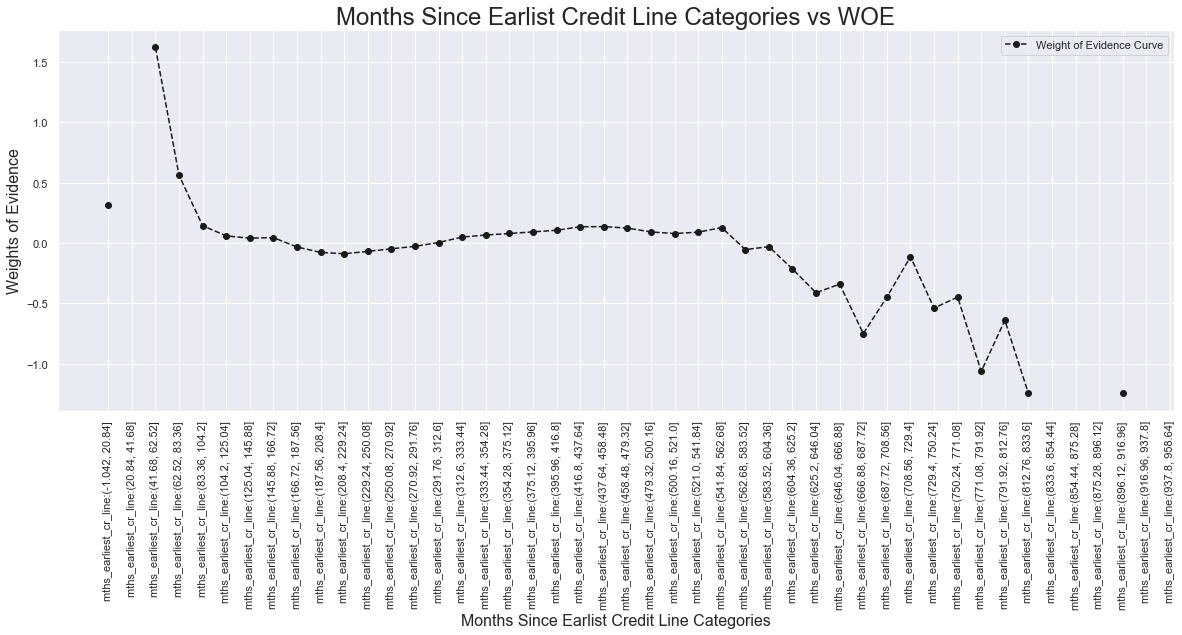

,n_obs,proba_n_obs,pos_obs,proba_pos_obs,neg_obs,proba_neg_obs,woe,woe_diff,iv
"mths_earliest_cr_line:(-1.042, 20.84]",21,1.16116e-05,19,1.20158e-05,2,8.79976e-06,0.311496,NaN,NaN
"mths_earliest_cr_line:(20.84, 41.68]",0,0,0,0,0,0,NaN,NaN,NaN
"mths_earliest_cr_line:(41.68, 62.52]",5386,0.0029781,5237,0.00331193,149,0.000655582,1.61976,NaN,NaN
"mths_earliest_cr_line:(62.52, 83.36]",27317,0.0151045,25245,0.0159652,2072,0.00911655,0.560318,-1.05944,NaN
"mths_earliest_cr_line:(83.36, 104.2]",46742,0.0258452,41564,0.0262855,5178,0.0227826,0.14302,-0.417298,NaN
"mths_earliest_cr_line:(104.2, 125.04]",56126,0.031034,49428,0.0312587,6698,0.0294704,0.0589123,-0.0841074,NaN
"mths_earliest_cr_line:(125.04, 145.88]",70791,0.0391428,62199,0.0393352,8592,0.0378038,0.0397116,-0.0192007,NaN
"mths_earliest_cr_line:(145.88, 166.72]",157791,0.087248,138718,0.0877265,19073,0.0839189,0.0443736,0.00466199,NaN
"mths_earliest_cr_line:(166.72, 187.56]",198102,0.109537,172481,0.109079,25621,0.112729,-0.032921,-0.0772946,NaN
"mths_earliest_cr_line:(187.56, 208.4]",195847,0.10829,169501,0.107194,26346,0.115919,-0.0782534,-0.0453324,NaN


In [80]:
calc_woe_df(mths_earliest_cr_line_df_dummies_train, train_targets, 'Months Since Earlist Credit Line', 90)

#### Removing Categories which give Null/Inf/NaN values as WOE

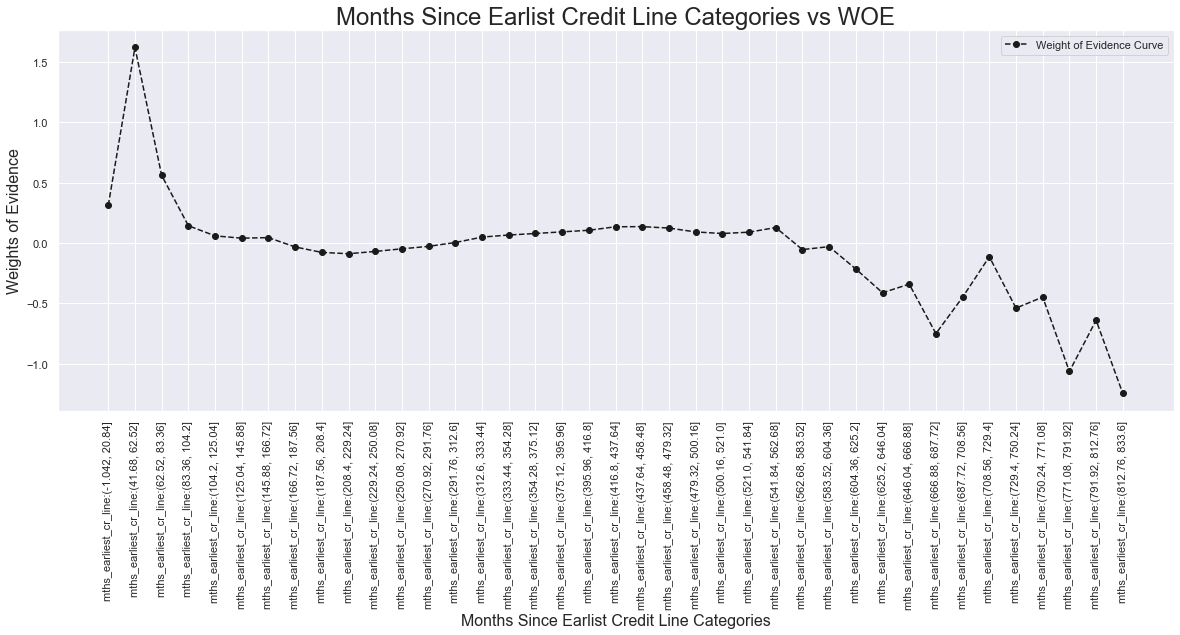

,n_obs,proba_n_obs,pos_obs,proba_pos_obs,neg_obs,proba_neg_obs,woe,woe_diff,iv
"mths_earliest_cr_line:(-1.042, 20.84]",21,1.16116e-05,19,1.20158e-05,2,8.79976e-06,0.311496,NaN,0.013293
"mths_earliest_cr_line:(41.68, 62.52]",5386,0.0029781,5237,0.00331193,149,0.000655582,1.61976,1.30827,0.013293
"mths_earliest_cr_line:(62.52, 83.36]",27317,0.0151045,25245,0.0159652,2072,0.00911655,0.560318,-1.05944,0.013293
"mths_earliest_cr_line:(83.36, 104.2]",46742,0.0258452,41564,0.0262855,5178,0.0227826,0.14302,-0.417298,0.013293
"mths_earliest_cr_line:(104.2, 125.04]",56126,0.031034,49428,0.0312587,6698,0.0294704,0.0589123,-0.0841074,0.013293
"mths_earliest_cr_line:(125.04, 145.88]",70791,0.0391428,62199,0.0393352,8592,0.0378038,0.0397116,-0.0192007,0.013293
"mths_earliest_cr_line:(145.88, 166.72]",157791,0.087248,138718,0.0877265,19073,0.0839189,0.0443736,0.00466199,0.013293
"mths_earliest_cr_line:(166.72, 187.56]",198102,0.109537,172481,0.109079,25621,0.112729,-0.032921,-0.0772946,0.013293
"mths_earliest_cr_line:(187.56, 208.4]",195847,0.10829,169501,0.107194,26346,0.115919,-0.0782534,-0.0453324,0.013293
"mths_earliest_cr_line:(208.4, 229.24]",186406,0.10307,161094,0.101877,25312,0.11137,-0.0890863,-0.0108329,0.013293


In [81]:
to_remove = ['mths_earliest_cr_line:(20.84, 41.68]', 'mths_earliest_cr_line:(833.6, 854.44]', 'mths_earliest_cr_line:(854.44, 875.28]', 'mths_earliest_cr_line:(875.28, 896.12]', 'mths_earliest_cr_line:(896.12, 916.96]', 'mths_earliest_cr_line:(916.96, 937.8]', 'mths_earliest_cr_line:(937.8, 958.64]', 'mths_earliest_cr_line:(958.64, 979.48]', 'mths_earliest_cr_line:(979.48, 1000.32]', 'mths_earliest_cr_line:(1000.32, 1021.16]', 'mths_earliest_cr_line:(1021.16, 1042.0]' ]
calc_woe_df(mths_earliest_cr_line_df_dummies_train.drop(to_remove, axis=1), train_targets, 'Months Since Earlist Credit Line', 90)

#### Training Features of mths_earliest_cr_line column

In [82]:
mths_earliest_cr_line_training_features_df = pd.DataFrame(columns = [
    'mths_earliest_cr_line:0_60',
    'mths_earliest_cr_line:60_80',
    'mths_earliest_cr_line:80_100',
    'mths_earliest_cr_line:100_560',
    'mths_earliest_cr_line:560+'
], index=train_indices)

mths_earliest_cr_line_training_features_df['mths_earliest_cr_line:0_60'] = np.where(( (mths_earliest_cr_line_df_train['mths_earliest_cr_line']>=0) & (mths_earliest_cr_line_df_train['mths_earliest_cr_line']<60) ), 1, 0)
mths_earliest_cr_line_training_features_df['mths_earliest_cr_line:60_80'] = np.where(( (mths_earliest_cr_line_df_train['mths_earliest_cr_line']>=60) & (mths_earliest_cr_line_df_train['mths_earliest_cr_line']<80) ), 1, 0)
mths_earliest_cr_line_training_features_df['mths_earliest_cr_line:80_100'] = np.where(( (mths_earliest_cr_line_df_train['mths_earliest_cr_line']>=80) & (mths_earliest_cr_line_df_train['mths_earliest_cr_line']<100) ), 1, 0)
mths_earliest_cr_line_training_features_df['mths_earliest_cr_line:100_560'] = np.where(( (mths_earliest_cr_line_df_train['mths_earliest_cr_line']>=100) & (mths_earliest_cr_line_df_train['mths_earliest_cr_line']<560) ), 1, 0)
mths_earliest_cr_line_training_features_df['mths_earliest_cr_line:560+'] = np.where(( (mths_earliest_cr_line_df_train['mths_earliest_cr_line']>=560) ), 1, 0)

#### Testing Features of mths_earliest_cr_line column

In [83]:
mths_earliest_cr_line_testing_features_df = pd.DataFrame(columns = [
    'mths_earliest_cr_line:0_60',
    'mths_earliest_cr_line:60_80',
    'mths_earliest_cr_line:80_100',
    'mths_earliest_cr_line:100_560',
    'mths_earliest_cr_line:560+'
], index=test_indices)

mths_earliest_cr_line_testing_features_df['mths_earliest_cr_line:0_60'] = np.where(( (mths_earliest_cr_line_df_test['mths_earliest_cr_line']>=0) & (mths_earliest_cr_line_df_test['mths_earliest_cr_line']<60) ), 1, 0)
mths_earliest_cr_line_testing_features_df['mths_earliest_cr_line:60_80'] = np.where(( (mths_earliest_cr_line_df_test['mths_earliest_cr_line']>=60) & (mths_earliest_cr_line_df_test['mths_earliest_cr_line']<80) ), 1, 0)
mths_earliest_cr_line_testing_features_df['mths_earliest_cr_line:80_100'] = np.where(( (mths_earliest_cr_line_df_test['mths_earliest_cr_line']>=80) & (mths_earliest_cr_line_df_test['mths_earliest_cr_line']<100) ), 1, 0)
mths_earliest_cr_line_testing_features_df['mths_earliest_cr_line:100_560'] = np.where(( (mths_earliest_cr_line_df_test['mths_earliest_cr_line']>=100) & (mths_earliest_cr_line_df_test['mths_earliest_cr_line']<560) ), 1, 0)
mths_earliest_cr_line_testing_features_df['mths_earliest_cr_line:560+'] = np.where(( (mths_earliest_cr_line_df_test['mths_earliest_cr_line']>=560) ), 1, 0)

#### Adding mths_earliest_cr_line feature to the set of training and testing features

In [84]:
training_features_df = pd.concat((training_features_df, mths_earliest_cr_line_training_features_df), axis=1)
testing_features_df = pd.concat((testing_features_df, mths_earliest_cr_line_testing_features_df), axis=1)

## Installment

In [85]:
installment_df_backup = pd.read_csv('Columns/installment.csv')
installment_df = installment_df_backup[['installment']]

#### Range of  Values

In [86]:
installment_df['installment'].describe()

count    2.260668e+06
mean     4.458076e+02
std      2.671737e+02
min      4.930000e+00
25%      2.516500e+02
50%      3.779900e+02
75%      5.933200e+02
max      1.719830e+03
Name: installment, dtype: float64

#### Missing Values

In [87]:
installment_df['installment'].isna().sum()

0

#### installment Column train test split

In [88]:
installment_df_train, installment_df_test = installment_df.iloc[train_indices], installment_df.iloc[test_indices]

#### Fine Classing installment into Categories and creating dummies

In [89]:
installment_df_dummies = pd.get_dummies(pd.cut(installment_df['installment'], 20), prefix='installment', prefix_sep=':')

#### installment dummies Column train test split

In [90]:
installment_df_dummies_train, installment_df_dummies_test = installment_df_dummies.iloc[train_indices], installment_df_dummies.iloc[test_indices]

#### installment column WOE dataframe and plot

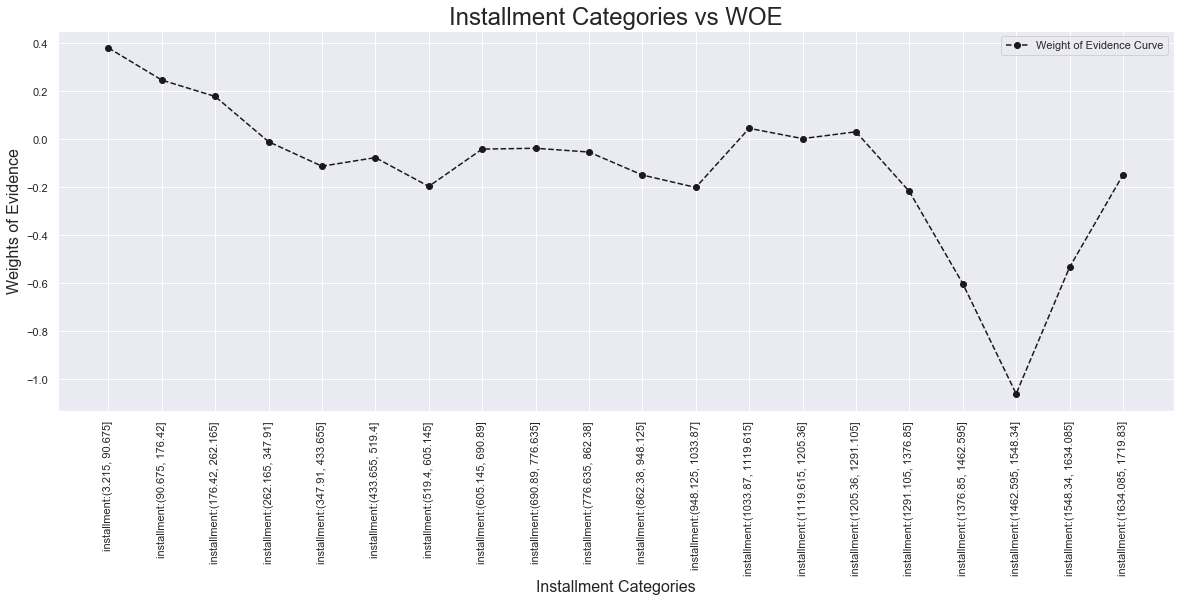

,n_obs,proba_n_obs,pos_obs,proba_pos_obs,neg_obs,proba_neg_obs,woe,woe_diff,iv
"installment:(3.215, 90.675]",55632,0.0307608,50661,0.0320385,4971,0.0218718,0.38174,NaN,0.021677
"installment:(90.675, 176.42]",182681,0.101011,164250,0.103873,18431,0.0810942,0.24756,-0.13418,0.021677
"installment:(176.42, 262.165]",251021,0.138798,224096,0.14172,26925,0.118467,0.179224,-0.0683363,0.021677
"installment:(262.165, 347.91]",321453,0.177742,280720,0.17753,40733,0.17922,-0.00947662,-0.1887,0.021677
"installment:(347.91, 433.655]",224146,0.123938,193119,0.12213,31027,0.136515,-0.111347,-0.10187,0.021677
"installment:(433.655, 519.4]",198810,0.109929,172127,0.108855,26683,0.117402,-0.0755899,0.0357571,0.021677
"installment:(519.4, 605.145]",141241,0.078097,120230,0.0760345,21011,0.0924458,-0.195435,-0.119845,0.021677
"installment:(605.145, 690.89]",128069,0.0708137,111401,0.070451,16668,0.0733372,-0.0401502,0.155285,0.021677
"installment:(690.89, 776.635]",81086,0.0448352,70565,0.0446259,10521,0.0462911,-0.0366348,0.00351542,0.021677
"installment:(776.635, 862.38]",69981,0.0386949,60776,0.0384353,9205,0.0405009,-0.0523476,-0.0157129,0.021677


In [91]:
calc_woe_df(installment_df_dummies_train, train_targets, 'Installment', 90)

#### Training Features of installment column

In [92]:
installment_training_features_df = pd.DataFrame(columns = [
    'installment:0_100',
    'installment:100_250',
    'installment:250_500',
    'installment:500_1000',
    'installment:1000_1300',
    'installment:1300+'
], index=train_indices)

installment_training_features_df['installment:0_100'] = np.where(( (installment_df_train['installment']>=0) & (installment_df_train['installment']<100) ), 1, 0)
installment_training_features_df['installment:100_250'] = np.where(( (installment_df_train['installment']>=100) & (installment_df_train['installment']<250) ), 1, 0)
installment_training_features_df['installment:250_500'] = np.where(( (installment_df_train['installment']>=250) & (installment_df_train['installment']<500) ), 1, 0)
installment_training_features_df['installment:500_1000'] = np.where(( (installment_df_train['installment']>=500) & (installment_df_train['installment']<1000) ), 1, 0)
installment_training_features_df['installment:1000_1300'] = np.where(( (installment_df_train['installment']>=1000) & (installment_df_train['installment']<1300) ), 1, 0)
installment_training_features_df['installment:1300+'] = np.where(( (installment_df_train['installment']>=1300) ), 1, 0)

#### Testing Features of installment column

In [93]:
installment_testing_features_df = pd.DataFrame(columns = [
    'installment:0_100',
    'installment:100_250',
    'installment:250_500',
    'installment:500_1000',
    'installment:1000_1300',
    'installment:1300+'
], index=test_indices)

installment_testing_features_df['installment:0_100'] = np.where(( (installment_df_test['installment']>=0) & (installment_df_test['installment']<100) ), 1, 0)
installment_testing_features_df['installment:100_250'] = np.where(( (installment_df_test['installment']>=100) & (installment_df_test['installment']<250) ), 1, 0)
installment_testing_features_df['installment:250_500'] = np.where(( (installment_df_test['installment']>=250) & (installment_df_test['installment']<500) ), 1, 0)
installment_testing_features_df['installment:500_1000'] = np.where(( (installment_df_test['installment']>=500) & (installment_df_test['installment']<1000) ), 1, 0)
installment_testing_features_df['installment:1000_1300'] = np.where(( (installment_df_test['installment']>=1000) & (installment_df_test['installment']<1300) ), 1, 0)
installment_testing_features_df['installment:1300+'] = np.where(( (installment_df_test['installment']>=1300) ), 1, 0)

#### Adding installment feature to the set of training and testing features

In [94]:
training_features_df = pd.concat((training_features_df, installment_training_features_df), axis=1)
testing_features_df = pd.concat((testing_features_df, installment_testing_features_df), axis=1)

#### Updating Backup

In [95]:
training_features_df_continuous = training_features_df.copy()
testing_features_df_continuous = testing_features_df.copy()

## Delinquency in last 2 Years

In [96]:
delinq_2yrs_df_backup = pd.read_csv('Columns/delinq_2yrs.csv')
delinq_2yrs_df = delinq_2yrs_df_backup[['delinq_2yrs']]
delinq_2yrs_df['delinq_2yrs'] = delinq_2yrs_df['delinq_2yrs'].astype('int64')

#### Range of  Values

In [97]:
delinq_2yrs_df['delinq_2yrs'].unique()

array([ 0,  1,  2,  7,  4,  3,  6,  5,  8, 16, 14, 10, 11,  9, 17, 12, 21,
       15, 13, 19, 23, 24, 18, 58, 35, 20, 22, 29, 30, 26, 27, 39, 28, 25,
       32, 42, 36], dtype=int64)

In [98]:
delinq_2yrs_df['delinq_2yrs'].describe()

count    2.260668e+06
mean     3.068752e-01
std      8.672255e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      5.800000e+01
Name: delinq_2yrs, dtype: float64

#### Missing Values

In [99]:
delinq_2yrs_df['delinq_2yrs'].isna().sum()

0

#### delinq_2yrs Column train test split

In [100]:
delinq_2yrs_df_train, delinq_2yrs_df_test = delinq_2yrs_df.iloc[train_indices], delinq_2yrs_df.iloc[test_indices]

#### Fine Classing delinq_2yrs into Categories and creating dummies

In [101]:
# delinq_2yrs_df_dummies = pd.get_dummies(pd.cut(delinq_2yrs_df['delinq_2yrs'], 10), prefix='delinq_2yrs', prefix_sep=':')
delinq_2yrs_df_dummies = pd.DataFrame(columns=[
    'delinq_2yrs:0',
    'delinq_2yrs:1',
    'delinq_2yrs:2',
    'delinq_2yrs:3',
    'delinq_2yrs:4',
    'delinq_2yrs:5',
    'delinq_2yrs:5+'
])
delinq_2yrs_df_dummies['delinq_2yrs:0'] = np.where(delinq_2yrs_df['delinq_2yrs'] == 0, 1, 0)
delinq_2yrs_df_dummies['delinq_2yrs:1'] = np.where(delinq_2yrs_df['delinq_2yrs'] == 1, 1, 0)
delinq_2yrs_df_dummies['delinq_2yrs:2'] = np.where(delinq_2yrs_df['delinq_2yrs'] == 2, 1, 0)
delinq_2yrs_df_dummies['delinq_2yrs:3'] = np.where(delinq_2yrs_df['delinq_2yrs'] == 3, 1, 0)
delinq_2yrs_df_dummies['delinq_2yrs:4'] = np.where(delinq_2yrs_df['delinq_2yrs'] == 4, 1, 0)
delinq_2yrs_df_dummies['delinq_2yrs:5'] = np.where(delinq_2yrs_df['delinq_2yrs'] == 5, 1, 0)
delinq_2yrs_df_dummies['delinq_2yrs:5+'] = np.where(delinq_2yrs_df['delinq_2yrs'] > 5, 1, 0)

#### delinq_2yrs dummies Column train test split

In [102]:
delinq_2yrs_df_dummies_train, delinq_2yrs_df_dummies_test = delinq_2yrs_df_dummies.iloc[train_indices], delinq_2yrs_df_dummies.iloc[test_indices]

#### delinq_2yrs column WOE dataframe and plot

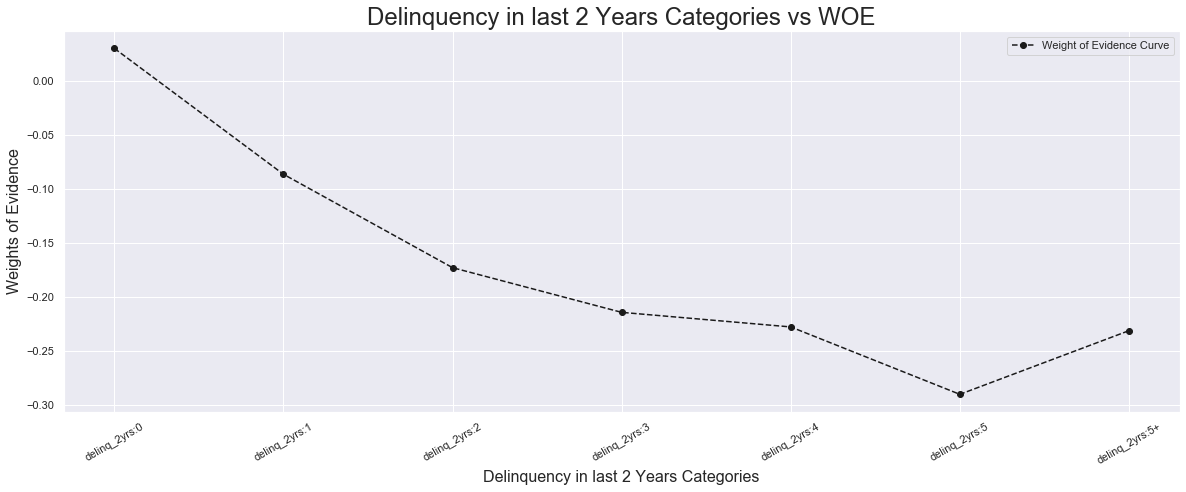

,n_obs,proba_n_obs,pos_obs,proba_pos_obs,neg_obs,proba_neg_obs,woe,woe_diff,iv
delinq_2yrs:0,1471443,0.813611,1291342,0.816656,180101,0.792423,0.0301237,NaN,0.004339
delinq_2yrs:1,224968,0.124392,194488,0.122996,30480,0.134108,-0.086496,-0.11662,0.004339
delinq_2yrs:2,65018,0.0359507,55529,0.035117,9489,0.0417504,-0.173024,-0.0865276,0.004339
delinq_2yrs:3,23720,0.0131156,20134,0.0127329,3586,0.015778,-0.214423,-0.0413996,0.004339
delinq_2yrs:4,10476,0.00579254,8874,0.005612,1602,0.00704861,-0.227923,-0.0134997,0.004339
delinq_2yrs:5,5261,0.00290899,4413,0.00279082,848,0.0037311,-0.290366,-0.0624434,0.004339
delinq_2yrs:5+,7648,0.00422884,6475,0.00409485,1173,0.00516106,-0.231412,0.0589547,0.004339


In [103]:
calc_woe_df(delinq_2yrs_df_dummies_train, train_targets, 'Delinquency in last 2 Years', 30)

#### Training Features of delinq_2yrs column

In [104]:
delinq_2yrs_training_features_df = pd.DataFrame(columns = [
    'delinq_2yrs:0',
    'delinq_2yrs:1',
    'delinq_2yrs:2',
    'delinq_2yrs:2+'
], index=train_indices)

delinq_2yrs_training_features_df['delinq_2yrs:0'] = np.where(delinq_2yrs_df_train['delinq_2yrs']==0, 1, 0)
delinq_2yrs_training_features_df['delinq_2yrs:1'] = np.where(delinq_2yrs_df_train['delinq_2yrs']==1, 1, 0)
delinq_2yrs_training_features_df['delinq_2yrs:2'] = np.where(delinq_2yrs_df_train['delinq_2yrs']==2, 1, 0)
delinq_2yrs_training_features_df['delinq_2yrs:2+'] = np.where(delinq_2yrs_df_train['delinq_2yrs']>2, 1, 0)

#### Testing Features of delinq_2yrs column

In [105]:
delinq_2yrs_testing_features_df = pd.DataFrame(columns = [
    'delinq_2yrs:0',
    'delinq_2yrs:1',
    'delinq_2yrs:2',
    'delinq_2yrs:2+'
], index=test_indices)

delinq_2yrs_testing_features_df['delinq_2yrs:0'] = np.where(delinq_2yrs_df_test['delinq_2yrs']==0, 1, 0)
delinq_2yrs_testing_features_df['delinq_2yrs:1'] = np.where(delinq_2yrs_df_test['delinq_2yrs']==1, 1, 0)
delinq_2yrs_testing_features_df['delinq_2yrs:2'] = np.where(delinq_2yrs_df_test['delinq_2yrs']==2, 1, 0)
delinq_2yrs_testing_features_df['delinq_2yrs:2+'] = np.where(delinq_2yrs_df_test['delinq_2yrs']>2, 1, 0)

#### Adding delinq_2yrs feature to the set of training and testing features

In [106]:
training_features_df = pd.concat((training_features_df, delinq_2yrs_training_features_df), axis=1)
testing_features_df = pd.concat((testing_features_df, delinq_2yrs_testing_features_df), axis=1)

#### Updating Backups

In [107]:
training_features_df_continuous = training_features_df.copy()
testing_features_df_continuous = testing_features_df.copy()

## Inquiries in the Last 6 Months

In [108]:
inq_last_6mths_df_backup = pd.read_csv('Columns/inq_last_6mths.csv')
inq_last_6mths_df = inq_last_6mths_df_backup[['inq_last_6mths']]
inq_last_6mths_df['inq_last_6mths'] = inq_last_6mths_df['inq_last_6mths'].astype('int64')

#### Range of  Values

In [109]:
inq_last_6mths_df['inq_last_6mths'].unique()

array([ 1,  0,  3,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 15, 14, 33, 17,
       32, 24, 13, 18, 16, 31, 28, 25, 27, 20, 19], dtype=int64)

In [110]:
inq_last_6mths_df['inq_last_6mths'].describe()

count    2.260668e+06
mean     5.768277e-01
std      8.859598e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      3.300000e+01
Name: inq_last_6mths, dtype: float64

#### Missing Values

In [111]:
inq_last_6mths_df['inq_last_6mths'].isna().sum()

0

#### inq_last_6mths Column train test split

In [112]:
inq_last_6mths_df_train, inq_last_6mths_df_test = inq_last_6mths_df.iloc[train_indices], inq_last_6mths_df.iloc[test_indices]

#### Distribution of Inquiries

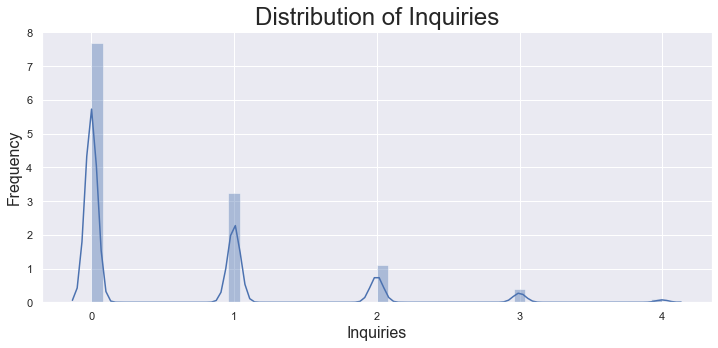

In [113]:
plt.figure(figsize = (12, 5))

sns.distplot(inq_last_6mths_df_train[inq_last_6mths_df_train['inq_last_6mths'] < 5])

plt.title('Distribution of Inquiries', size=24)
plt.xlabel('Inquiries', size=16)
plt.ylabel('Frequency', size=16)

plt.show()

#### Fine Classing inq_last_6mths into Categories and creating dummies

In [114]:
# inq_last_6mths_df_dummies = pd.get_dummies(pd.cut(inq_last_6mths_df['inq_last_6mths'], 10), prefix='inq_last_6mths', prefix_sep=':')
inq_last_6mths_df_dummies = pd.DataFrame(columns=[
    'inq_last_6mths:0',
    'inq_last_6mths:1',
    'inq_last_6mths:2',
    'inq_last_6mths:2+'
])
inq_last_6mths_df_dummies['inq_last_6mths:0'] = np.where(inq_last_6mths_df['inq_last_6mths'] == 0, 1, 0)
inq_last_6mths_df_dummies['inq_last_6mths:1'] = np.where(inq_last_6mths_df['inq_last_6mths'] == 1, 1, 0)
inq_last_6mths_df_dummies['inq_last_6mths:2'] = np.where(inq_last_6mths_df['inq_last_6mths'] == 2, 1, 0)
inq_last_6mths_df_dummies['inq_last_6mths:2+'] = np.where(inq_last_6mths_df['inq_last_6mths'] > 2, 1, 0)

#### inq_last_6mths dummies Column train test split

In [115]:
inq_last_6mths_df_dummies_train, inq_last_6mths_df_dummies_test = inq_last_6mths_df_dummies.iloc[train_indices], inq_last_6mths_df_dummies.iloc[test_indices]

#### inq_last_6mths column WOE dataframe and plot

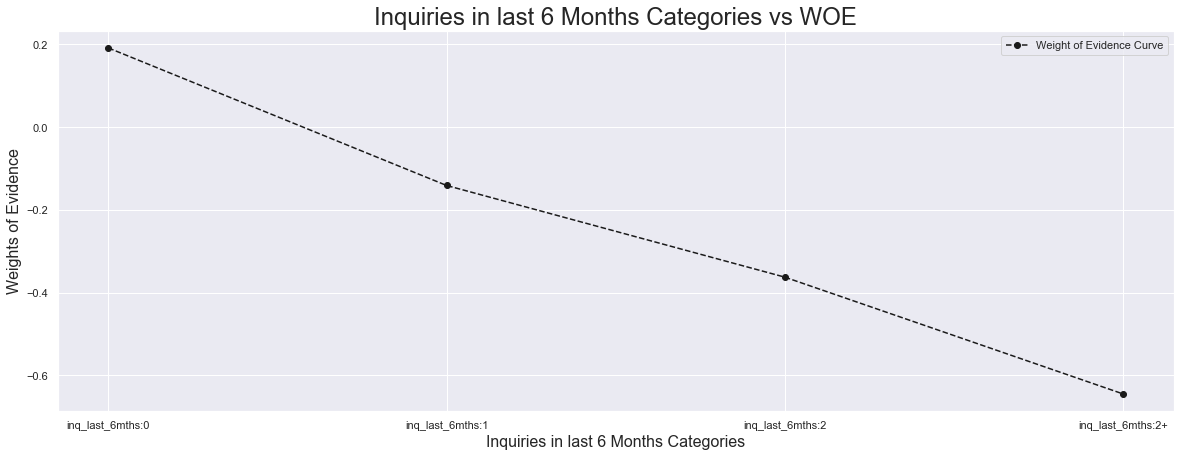

,n_obs,proba_n_obs,pos_obs,proba_pos_obs,neg_obs,proba_neg_obs,woe,woe_diff,iv
inq_last_6mths:0,1105491,0.611264,988213,0.624955,117278,0.516009,0.191555,NaN,0.06142
inq_last_6mths:1,467442,0.258465,401073,0.253642,66369,0.292016,-0.140882,-0.332438,0.06142
inq_last_6mths:2,160218,0.08859,132793,0.0839795,27425,0.120667,-0.362459,-0.221577,0.06142
inq_last_6mths:2+,75383,0.0416818,59176,0.0374234,16207,0.0713088,-0.644723,-0.282264,0.06142


In [116]:
calc_woe_df(inq_last_6mths_df_dummies_train, train_targets, 'Inquiries in last 6 Months', 0)

#### Training Features of inq_last_6mths column

In [117]:
inq_last_6mths_training_features_df = pd.DataFrame(columns = [
    'inq_last_6mths:0',
    'inq_last_6mths:1',
    'inq_last_6mths:2',
    'inq_last_6mths:2+'
], index=train_indices)

inq_last_6mths_training_features_df['inq_last_6mths:0'] = np.where(inq_last_6mths_df_train['inq_last_6mths']==0, 1, 0)
inq_last_6mths_training_features_df['inq_last_6mths:1'] = np.where(inq_last_6mths_df_train['inq_last_6mths']==1, 1, 0)
inq_last_6mths_training_features_df['inq_last_6mths:2'] = np.where(inq_last_6mths_df_train['inq_last_6mths']==2, 1, 0)
inq_last_6mths_training_features_df['inq_last_6mths:2+'] = np.where(inq_last_6mths_df_train['inq_last_6mths']>2, 1, 0)

#### Testing Features of inq_last_6mths column

In [118]:
inq_last_6mths_testing_features_df = pd.DataFrame(columns = [
    'inq_last_6mths:0',
    'inq_last_6mths:1',
    'inq_last_6mths:2',
    'inq_last_6mths:2+'
], index=test_indices)

inq_last_6mths_testing_features_df['inq_last_6mths:0'] = np.where(inq_last_6mths_df_test['inq_last_6mths']==0, 1, 0)
inq_last_6mths_testing_features_df['inq_last_6mths:1'] = np.where(inq_last_6mths_df_test['inq_last_6mths']==1, 1, 0)
inq_last_6mths_testing_features_df['inq_last_6mths:2'] = np.where(inq_last_6mths_df_test['inq_last_6mths']==2, 1, 0)
inq_last_6mths_testing_features_df['inq_last_6mths:2+'] = np.where(inq_last_6mths_df_test['inq_last_6mths']>2, 1, 0)

#### Adding inq_last_6mths feature to the set of training and testing features

In [119]:
training_features_df = pd.concat((training_features_df, inq_last_6mths_training_features_df), axis=1)
testing_features_df = pd.concat((testing_features_df, inq_last_6mths_testing_features_df), axis=1)

#### Updating Backups

In [120]:
training_features_df_continuous = training_features_df.copy()
testing_features_df_continuous = testing_features_df.copy()

## Open Account

In [121]:
open_acc_df_backup = pd.read_csv('Columns/open_acc.csv')
open_acc_df = open_acc_df_backup[['open_acc']]
open_acc_df['open_acc'] = open_acc_df['open_acc'].astype('int64')

#### Range of  Values

In [122]:
open_acc_df['open_acc'].unique()

array([  9,  13,   8,  10,  12,  18,   1,  19,  38,   6,  20,  27,   7,
         4,  14,  17,   5,  11,   3,  16,  15,  24,  23,  26,  22,  21,
        25,  29,   2,  44,  28,  31,  34,  32,  30,  35,  41,  36,  40,
        33,  45,  43,  37,  59,  39,   0,  55,  48,  60,  47,  42,  51,
        66,  49,  53,  57,  50,  46,  54,  61,  63,  68,  52,  64,  62,
        69,  94,  70,  58,  78,  56,  82, 101,  86,  65,  72,  80,  77,
        81,  71,  74,  97,  67,  79,  90,  76,  93,  91,  88,  84,  75],
      dtype=int64)

In [123]:
open_acc_df['open_acc'].describe()

count    2.260668e+06
mean     1.161225e+01
std      5.640978e+00
min      0.000000e+00
25%      8.000000e+00
50%      1.100000e+01
75%      1.400000e+01
max      1.010000e+02
Name: open_acc, dtype: float64

#### Missing Values

In [124]:
open_acc_df['open_acc'].isna().sum()

0

#### open_acc Column train test split

In [125]:
open_acc_df_train, open_acc_df_test = open_acc_df.iloc[train_indices], open_acc_df.iloc[test_indices]

#### Distribution of open_accounts

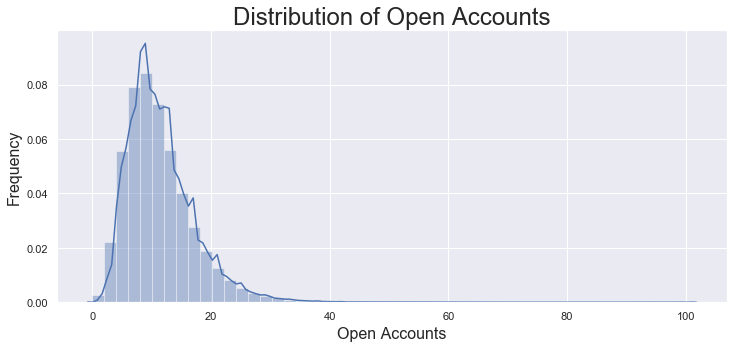

In [126]:
plt.figure(figsize = (12, 5))

sns.distplot(open_acc_df_train)

plt.title('Distribution of Open Accounts', size=24)
plt.xlabel('Open Accounts', size=16)
plt.ylabel('Frequency', size=16)

plt.show()

#### Fine Classing open_acc into Categories and creating dummies

In [127]:
# open_acc_df_dummies = pd.get_dummies(pd.cut(open_acc_df['open_acc'], 10), prefix='open_acc', prefix_sep=':')
open_acc_df_dummies = pd.DataFrame(columns=[
    'open_acc:0_5',
    'open_acc:5_10',
    'open_acc:10_15',
    'open_acc:15_20',
    'open_acc:20_25',
    'open_acc:25+',
])
open_acc_df_dummies['open_acc:0_5'] = np.where(((open_acc_df['open_acc'] >= 0) & (open_acc_df['open_acc'] < 5)), 1, 0)
open_acc_df_dummies['open_acc:5_10'] = np.where(((open_acc_df['open_acc'] >= 5) & (open_acc_df['open_acc'] < 10)), 1, 0)
open_acc_df_dummies['open_acc:10_15'] = np.where(((open_acc_df['open_acc'] >= 10) & (open_acc_df['open_acc'] < 15)), 1, 0)
open_acc_df_dummies['open_acc:15_20'] = np.where(((open_acc_df['open_acc'] >= 15) & (open_acc_df['open_acc'] < 20)), 1, 0)
open_acc_df_dummies['open_acc:20_25'] = np.where(((open_acc_df['open_acc'] >= 20) & (open_acc_df['open_acc'] < 25)), 1, 0)
open_acc_df_dummies['open_acc:25+'] = np.where(open_acc_df['open_acc'] >= 25, 1, 0)

#### open_acc dummies Column train test split

In [128]:
open_acc_df_dummies_train, open_acc_df_dummies_test = open_acc_df_dummies.iloc[train_indices], open_acc_df_dummies.iloc[test_indices]

#### open_acc column WOE dataframe and plot

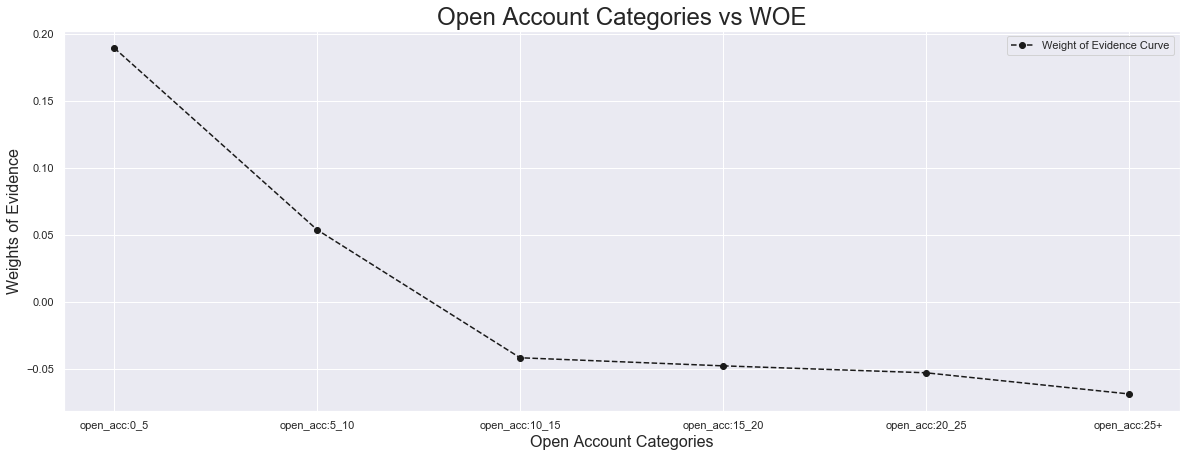

,n_obs,proba_n_obs,pos_obs,proba_pos_obs,neg_obs,proba_neg_obs,woe,woe_diff,iv
open_acc:0_5,90520,0.0500516,80898,0.0511606,9622,0.0423356,0.189341,NaN,0.003983
open_acc:5_10,649480,0.35912,571608,0.36149,77872,0.342627,0.0535912,-0.13575,0.003983
open_acc:10_15,622109,0.343985,541016,0.342143,81093,0.356799,-0.0419436,-0.0955348,0.003983
open_acc:15_20,286094,0.158191,248605,0.15722,37489,0.164947,-0.047978,-0.00603447,0.003983
open_acc:20_25,105851,0.0585286,91918,0.0581298,13933,0.0613035,-0.053159,-0.00518099,0.003983
open_acc:25+,54480,0.0301238,47210,0.029856,7270,0.0319871,-0.0689463,-0.0157873,0.003983


In [129]:
calc_woe_df(open_acc_df_dummies_train, train_targets, 'Open Account', 0)

#### Training Features of open_acc column

In [130]:
open_acc_training_features_df = pd.DataFrame(columns = [
    'open_acc:0_5',
    'open_acc:5_10',
    'open_acc:10+'
], index=train_indices)

open_acc_training_features_df['open_acc:0_5'] = np.where(((open_acc_df_train['open_acc'] >= 0) & (open_acc_df_train['open_acc'] < 5)), 1, 0)
open_acc_training_features_df['open_acc:5_10'] = np.where(((open_acc_df_train['open_acc'] >= 5) & (open_acc_df_train['open_acc'] < 10)), 1, 0)
open_acc_training_features_df['open_acc:10+'] = np.where(open_acc_df_train['open_acc'] >= 10, 1, 0)

#### Testing Features of open_acc column

In [131]:
open_acc_testing_features_df = pd.DataFrame(columns = [
    'open_acc:0_5',
    'open_acc:5_10',
    'open_acc:10+'
], index=test_indices)

open_acc_testing_features_df['open_acc:0_5'] = np.where(((open_acc_df_test['open_acc'] >= 0) & (open_acc_df_test['open_acc'] < 5)), 1, 0)
open_acc_testing_features_df['open_acc:5_10'] = np.where(((open_acc_df_test['open_acc'] >= 5) & (open_acc_df_test['open_acc'] < 10)), 1, 0)
open_acc_testing_features_df['open_acc:10+'] = np.where(open_acc_df_test['open_acc'] >= 10, 1, 0)

#### Adding open_acc feature to the set of training and testing features

In [132]:
training_features_df = pd.concat((training_features_df, open_acc_training_features_df), axis=1)
testing_features_df = pd.concat((testing_features_df, open_acc_testing_features_df), axis=1)

#### Updating Backups

In [133]:
training_features_df_continuous = training_features_df.copy()
testing_features_df_continuous = testing_features_df.copy()

# Exporting CSV Files

In [ ]:
training_features_df.to_csv('training_features_df_continuous.csv', index=True)
testing_features_df.to_csv('testing_features_df_continuous.csv', index=True)

In [ ]:
training_features_df_continuous_imported_backup = pd.read_csv('training_features_df_continuous.csv')
testing_features_df_continuous_imported_backup = pd.read_csv('testing_features_df_continuous.csv')

In [ ]:
training_features_df = training_features_df_continuous_imported_backup.copy()
training_features_df = training_features_df.set_index('Unnamed: 0')

testing_features_df = testing_features_df_continuous_imported_backup.copy()
testing_features_df = testing_features_df.set_index('Unnamed: 0')

## Derogatory Public Records

In [134]:
pub_rec_df_backup = pd.read_csv('Columns/pub_rec.csv')
pub_rec_df = pub_rec_df_backup[['pub_rec']]
pub_rec_df['pub_rec'] = pub_rec_df['pub_rec'].astype('int64')

#### Range of  Values

In [135]:
pub_rec_df['pub_rec'].unique()

array([ 1,  0,  3,  2,  4,  5,  6,  8,  7, 15,  9, 10, 13, 24, 52, 19, 11,
       12, 21, 14, 45, 25, 28, 61, 17, 31, 20, 47, 16, 46, 22, 37, 23, 26,
       86, 18, 49, 32, 44, 54, 40, 63, 34], dtype=int64)

In [136]:
pub_rec_df['pub_rec'].describe()

count    2.260668e+06
mean     1.975252e-01
std      5.705118e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      8.600000e+01
Name: pub_rec, dtype: float64

#### Missing Values

In [137]:
pub_rec_df['pub_rec'].isna().sum()

0

#### pub_rec Column train test split

In [138]:
pub_rec_df_train, pub_rec_df_test = pub_rec_df.iloc[train_indices], pub_rec_df.iloc[test_indices]

#### Distribution of Derogatory Public Records

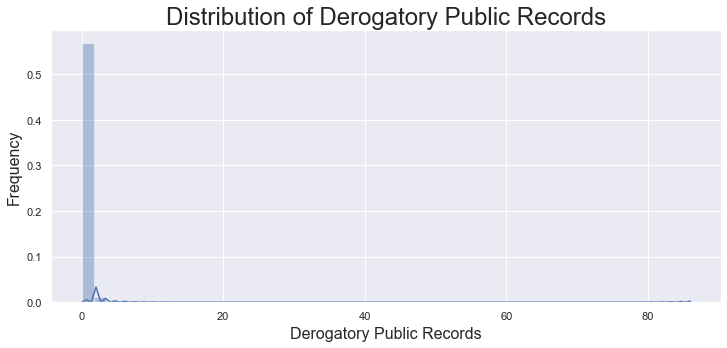

In [139]:
plt.figure(figsize = (12, 5))

sns.distplot(pub_rec_df_train)

plt.title('Distribution of Derogatory Public Records', size=24)
plt.xlabel('Derogatory Public Records', size=16)
plt.ylabel('Frequency', size=16)

plt.show()

#### Fine Classing pub_rec into Categories and creating dummies

In [140]:
# pub_rec_df_dummies = pd.get_dummies(pd.cut(pub_rec_df['pub_rec'], 10), prefix='pub_rec', prefix_sep=':')
pub_rec_df_dummies = pd.DataFrame(columns=[
    'pub_rec:0',
    'pub_rec:0+'
])
pub_rec_df_dummies['pub_rec:0'] = np.where(pub_rec_df['pub_rec'] >= 0, 1, 0)
pub_rec_df_dummies['pub_rec:0+'] = np.where(pub_rec_df['pub_rec'] > 0, 1, 0)

#### pub_rec dummies Column train test split

In [141]:
pub_rec_df_dummies_train, pub_rec_df_dummies_test = pub_rec_df_dummies.iloc[train_indices], pub_rec_df_dummies.iloc[test_indices]

#### pub_rec column WOE dataframe and plot

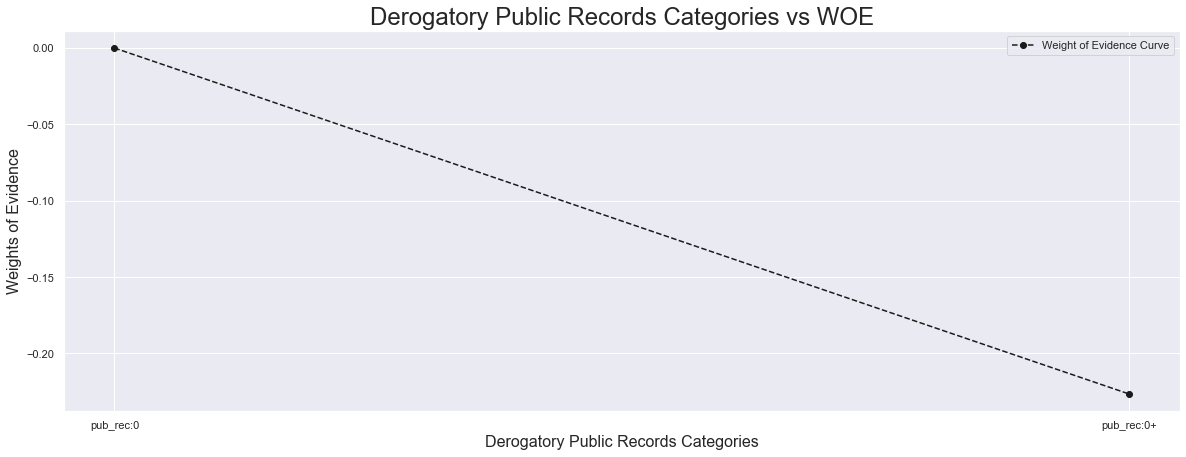

,n_obs,proba_n_obs,pos_obs,proba_pos_obs,neg_obs,proba_neg_obs,woe,woe_diff,iv
pub_rec:0,1808534,1,1581255,1,227279,1,0,NaN,0.008815
pub_rec:0+,285797,0.158027,242146,0.153135,43651,0.192059,-0.226481,-0.226481,0.008815


In [142]:
calc_woe_df(pub_rec_df_dummies_train, train_targets, 'Derogatory Public Records', 0)

#### Training Features of pub_rec column

In [143]:
pub_rec_training_features_df = pd.DataFrame(columns = [
    'pub_rec:0',
    'pub_rec:0+'
], index=train_indices)

pub_rec_training_features_df['pub_rec:0'] = np.where(pub_rec_df_train['pub_rec'] == 0, 1, 0)
pub_rec_training_features_df['pub_rec:0+'] = np.where(pub_rec_df_train['pub_rec'] > 0, 1, 0)

#### Testing Features of pub_rec column

In [144]:
pub_rec_testing_features_df = pd.DataFrame(columns = [
    'pub_rec:0',
    'pub_rec:0+'
], index=test_indices)

pub_rec_testing_features_df['pub_rec:0'] = np.where(pub_rec_df_test['pub_rec'] == 0, 1, 0)
pub_rec_testing_features_df['pub_rec:0+'] = np.where(pub_rec_df_test['pub_rec'] > 0, 1, 0)

#### Adding pub_rec feature to the set of training and testing features

In [145]:
training_features_df = pd.concat((training_features_df, pub_rec_training_features_df), axis=1)
testing_features_df = pd.concat((testing_features_df, pub_rec_testing_features_df), axis=1)

#### Updating Backups

In [146]:
training_features_df_continuous = training_features_df.copy()
testing_features_df_continuous = testing_features_df.copy()

## Total Account

In [147]:
total_acc_df_backup = pd.read_csv('Columns/total_acc.csv')
total_acc_df = total_acc_df_backup[['total_acc']]
total_acc_df['total_acc'] = total_acc_df['total_acc'].astype('int64')

#### Range of  Values

In [148]:
total_acc_df['total_acc'].unique()

array([ 34,  44,  13,  26,   9,  37,  38,  58,  23,  27,  41,  16,  21,
         8,  28,  17,  20,  18,  22,  30,  10,  24,  19,  46,  11,  12,
        15,  50,  29,  32,  25,  31,  56,  14,  33,   6,  64,  42,   4,
        51,  40,  36,  54,   7,  39,  49,   5,   3,  47,  59,  91,  35,
        43,  72,  45,  57,  55,  60,  76,  48,  52,  66,  77,   2,  53,
        94,  62,  68,  63,  67,  61,  82,  86,  69,  71,  70,  65,  73,
        74,  79,  84,  92,  80,  75,  88,  95,  85,  87,  90, 104,  78,
        83, 133,  89,  93, 106, 110,  97, 100,  96,  81, 128, 107, 101,
       105, 120,  98, 103, 160, 115, 145, 117,  99, 123, 102, 109, 118,
       111, 113, 148, 108, 114, 119, 138, 140, 112, 116, 153, 129, 125,
       173, 126, 157, 144, 176, 137, 121, 127, 135, 151, 130, 169, 146,
       124, 162, 122, 136, 141, 150, 156,   1,   0, 165], dtype=int64)

In [149]:
total_acc_df['total_acc'].describe()

count    2.260668e+06
mean     2.416224e+01
std      1.198776e+01
min      0.000000e+00
25%      1.500000e+01
50%      2.200000e+01
75%      3.100000e+01
max      1.760000e+02
Name: total_acc, dtype: float64

#### Missing Values

In [150]:
total_acc_df['total_acc'].isna().sum()

0

#### total_acc Column train test split

In [151]:
total_acc_df_train, total_acc_df_test = total_acc_df.iloc[train_indices], total_acc_df.iloc[test_indices]

#### Distribution of total_acc

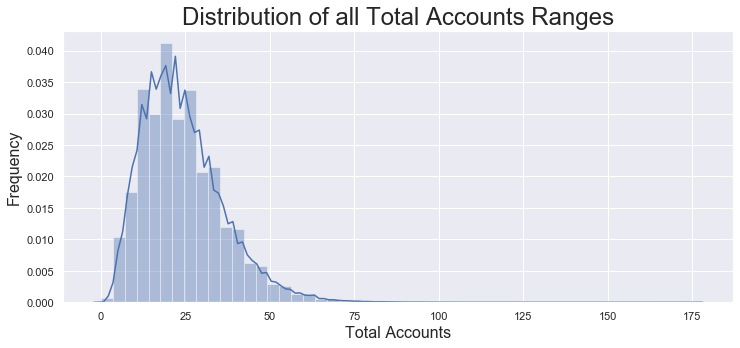

In [152]:
plt.figure(figsize = (12, 5))

sns.distplot(total_acc_df_train)

plt.title('Distribution of all Total Accounts Ranges', size=24)
plt.xlabel('Total Accounts', size=16)
plt.ylabel('Frequency', size=16)

plt.show()

#### Fine Classing total_acc into Categories and creating dummies

In [153]:
total_acc_df_t = pd.DataFrame(np.where(total_acc_df['total_acc']<75, total_acc_df['total_acc'], np.nan), columns=['total_acc'])

total_acc_df_dummies_t = pd.get_dummies(pd.cut(total_acc_df_t['total_acc'], 13), prefix='total_acc', prefix_sep=':')

#### total_acc dummies Column train test split

In [154]:
total_acc_df_dummies_train, total_acc_df_dummies_test = total_acc_df_dummies_t.iloc[train_indices], total_acc_df_dummies_t.iloc[test_indices]

#### total_acc column WOE dataframe and plot

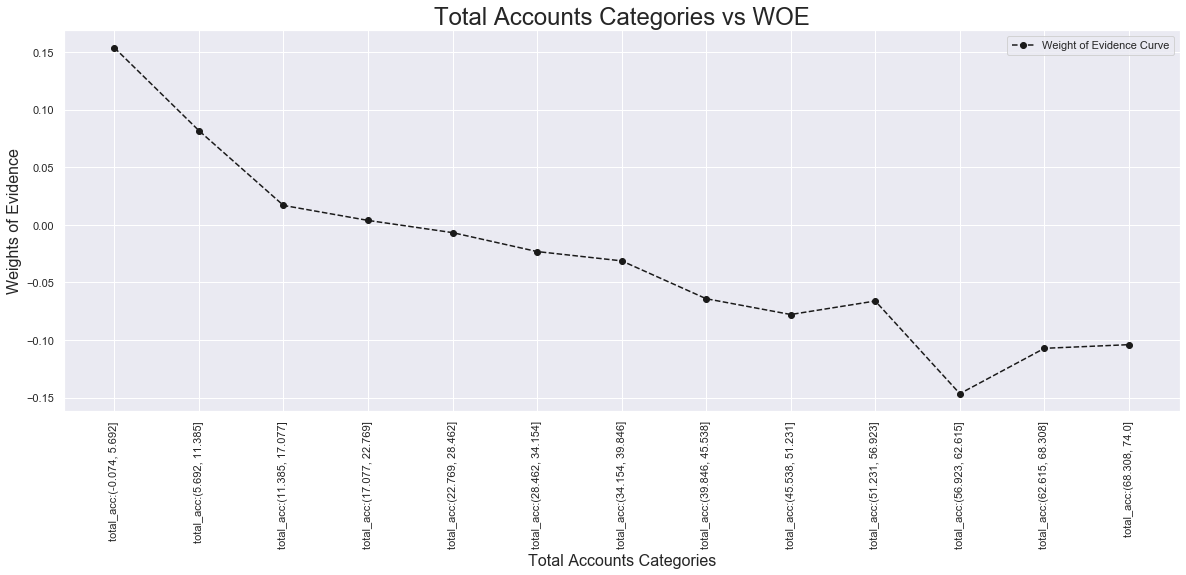

,n_obs,proba_n_obs,pos_obs,proba_pos_obs,neg_obs,proba_neg_obs,woe,woe_diff,iv
"total_acc:(-0.074, 5.692]",26172,0.0144714,23300,0.0147351,2872,0.0126365,0.153649,NaN,0.001949
"total_acc:(5.692, 11.385]",203593,0.112573,179780,0.113695,23813,0.104774,0.0817065,-0.0719425,0.001949
"total_acc:(11.385, 17.077]",358412,0.198178,314028,0.198594,44384,0.195284,0.0168073,-0.0648991,0.001949
"total_acc:(17.077, 22.769]",325315,0.179878,284568,0.179963,40747,0.179282,0.00379425,-0.0130131,0.001949
"total_acc:(22.769, 28.462]",336845,0.186253,294261,0.186093,42584,0.187364,-0.00680724,-0.0106015,0.001949
"total_acc:(28.462, 34.154]",238207,0.131713,207658,0.131325,30549,0.134412,-0.0232352,-0.016428,0.001949
"total_acc:(34.154, 39.846]",127835,0.0706843,111325,0.0704029,16510,0.072642,-0.0313082,-0.00807295,0.001949
"total_acc:(39.846, 45.538]",92519,0.0511569,80224,0.0507344,12295,0.0540965,-0.0641657,-0.0328575,0.001949
"total_acc:(45.538, 51.231]",49547,0.0273962,42884,0.0271202,6663,0.0293164,-0.0778668,-0.0137011,0.001949
"total_acc:(51.231, 56.923]",22040,0.0121867,19106,0.0120828,2934,0.0129092,-0.06616,0.0117068,0.001949


In [155]:
calc_woe_df(total_acc_df_dummies_train, train_targets, 'Total Accounts', 90)

#### Training Features of total_acc column

In [156]:
total_acc_training_features_df = pd.DataFrame(columns = [
    'total_acc:0_5',
    'total_acc:5_10',
    'total_acc:10_40',
    'total_acc:40+'
], index=train_indices)

total_acc_training_features_df['total_acc:0_5'] = np.where(((total_acc_df_train['total_acc'] >= 0) & (total_acc_df_train['total_acc'] < 5)), 1, 0)
total_acc_training_features_df['total_acc:5_10'] = np.where(((total_acc_df_train['total_acc'] >= 5) & (total_acc_df_train['total_acc'] < 10)), 1, 0)
total_acc_training_features_df['total_acc:10_40'] = np.where(((total_acc_df_train['total_acc'] >= 10) & (total_acc_df_train['total_acc'] < 40)), 1, 0)
total_acc_training_features_df['total_acc:40+'] = np.where(total_acc_df_train['total_acc'] >= 40, 1, 0)

#### Testing Features of total_acc column

In [157]:
total_acc_testing_features_df = pd.DataFrame(columns = [
    'total_acc:0_5',
    'total_acc:5_10',
    'total_acc:10_40',
    'total_acc:40+'
], index=test_indices)

total_acc_testing_features_df['total_acc:0_5'] = np.where(((total_acc_df_test['total_acc'] >= 0) & (total_acc_df_test['total_acc'] < 5)), 1, 0)
total_acc_testing_features_df['total_acc:5_10'] = np.where(((total_acc_df_test['total_acc'] >= 5) & (total_acc_df_test['total_acc'] < 10)), 1, 0)
total_acc_testing_features_df['total_acc:10_40'] = np.where(((total_acc_df_test['total_acc'] >= 10) & (total_acc_df_test['total_acc'] < 40)), 1, 0)
total_acc_testing_features_df['total_acc:40+'] = np.where(total_acc_df_test['total_acc'] >= 40, 1, 0)

#### Adding total_acc feature to the set of training and testing features

In [158]:
training_features_df = pd.concat((training_features_df, total_acc_training_features_df), axis=1)
testing_features_df = pd.concat((testing_features_df, total_acc_testing_features_df), axis=1)

#### Updating Backups

In [159]:
training_features_df_continuous = training_features_df.copy()
testing_features_df_continuous = testing_features_df.copy()

## Accounts now Delinquent

In [160]:
acc_now_delinq_df_backup = pd.read_csv('Columns/acc_now_delinq.csv')
acc_now_delinq_df = acc_now_delinq_df_backup[['acc_now_delinq']]
acc_now_delinq_df['acc_now_delinq'] = acc_now_delinq_df['acc_now_delinq'].fillna(0)
acc_now_delinq_df['acc_now_delinq'] = acc_now_delinq_df['acc_now_delinq'].astype('int64')

#### Range of  Values

In [161]:
acc_now_delinq_df['acc_now_delinq'].unique()

array([ 0,  1,  2,  3,  4,  6,  5, 14,  7], dtype=int64)

In [162]:
acc_now_delinq_df['acc_now_delinq'].describe()

count    2.260668e+06
mean     4.147889e-03
std      6.961612e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.400000e+01
Name: acc_now_delinq, dtype: float64

#### Missing Values

In [163]:
acc_now_delinq_df['acc_now_delinq'].isna().sum()

0

#### acc_now_delinq Column train test split

In [164]:
acc_now_delinq_df_train, acc_now_delinq_df_test = acc_now_delinq_df.iloc[train_indices], acc_now_delinq_df.iloc[test_indices]

#### Fine Classing acc_now_delinq into Categories and creating dummies

In [165]:
acc_now_delinq_df_dummies = pd.get_dummies(acc_now_delinq_df['acc_now_delinq'], prefix='acc_now_delinq', prefix_sep=':')

#### acc_now_delinq dummies Column train test split

In [166]:
acc_now_delinq_df_dummies_train, acc_now_delinq_df_dummies_test = acc_now_delinq_df_dummies.iloc[train_indices], acc_now_delinq_df_dummies.iloc[test_indices]

#### acc_now_delinq column WOE dataframe and plot

In [167]:
acc_now_delinq_df_dummies_train

,acc_now_delinq:0,acc_now_delinq:1,acc_now_delinq:2,acc_now_delinq:3,acc_now_delinq:4,acc_now_delinq:5,acc_now_delinq:6,acc_now_delinq:7,acc_now_delinq:14
305053,1,0,0,0,0,0,0,0,0
50247,1,0,0,0,0,0,0,0,0
1630001,1,0,0,0,0,0,0,0,0
927626,1,0,0,0,0,0,0,0,0
758488,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
732180,1,0,0,0,0,0,0,0,0
110268,1,0,0,0,0,0,0,0,0
1692743,1,0,0,0,0,0,0,0,0
2229084,1,0,0,0,0,0,0,0,0


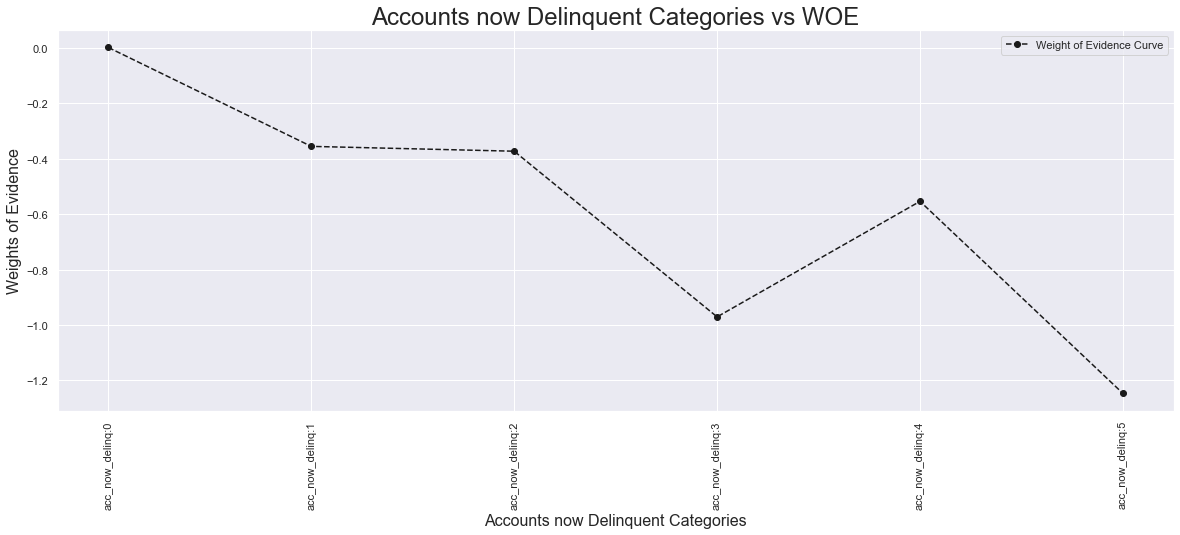

,n_obs,proba_n_obs,pos_obs,proba_pos_obs,neg_obs,proba_neg_obs,woe,woe_diff,iv
acc_now_delinq:0,1801431,0.996073,1575367,0.996276,226064,0.994654,0.00162962,NaN,NaN
acc_now_delinq:1,6712,0.00371129,5570,0.00352252,1142,0.00502466,-0.355182,-0.356811,NaN
acc_now_delinq:2,336,0.000185786,278,0.00017581,58,0.000255193,-0.372618,-0.0174358,NaN
acc_now_delinq:3,40,2.21174e-05,29,1.83399e-05,11,4.83987e-05,-0.970395,-0.597778,NaN
acc_now_delinq:4,10,5.52934e-06,8,5.05927e-06,2,8.79976e-06,-0.553501,0.416894,NaN
acc_now_delinq:5,3,1.6588e-06,2,1.26482e-06,1,4.39988e-06,-1.24665,-0.693147,NaN
acc_now_delinq:6,1,5.52934e-07,0,0,1,4.39988e-06,-inf,-inf,NaN
acc_now_delinq:7,0,0,0,0,0,0,NaN,NaN,NaN
acc_now_delinq:14,1,5.52934e-07,1,6.32409e-07,0,0,inf,NaN,NaN


In [168]:
calc_woe_df(acc_now_delinq_df_dummies_train, train_targets, 'Accounts now Delinquent', 90)

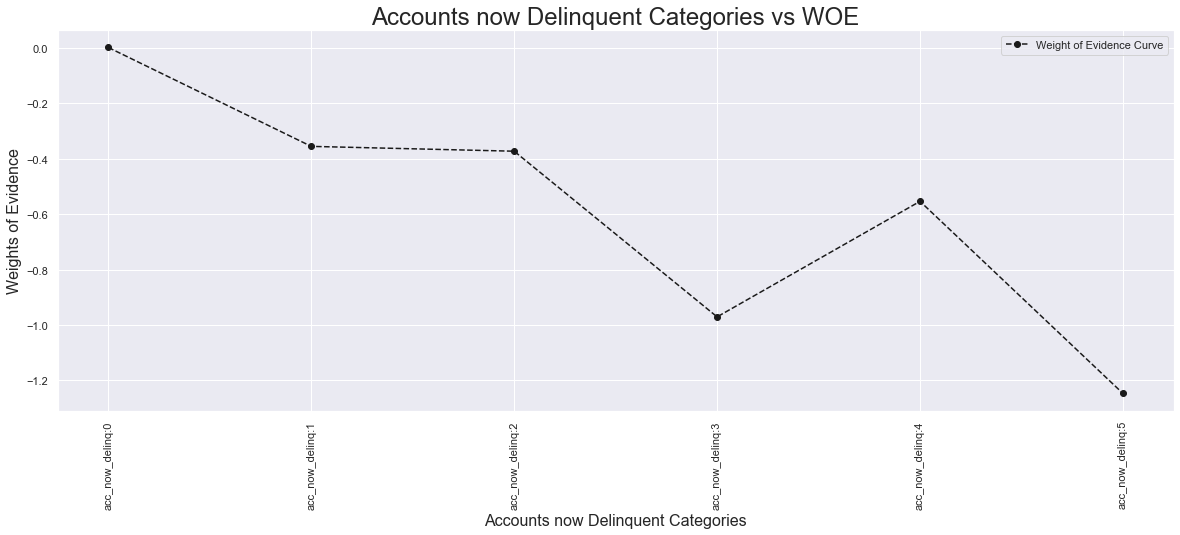

,n_obs,proba_n_obs,pos_obs,proba_pos_obs,neg_obs,proba_neg_obs,woe,woe_diff,iv
acc_now_delinq:0,1801431,0.996073,1575367,0.996276,226064,0.994654,0.00162962,NaN,0.000601
acc_now_delinq:1,6712,0.00371129,5570,0.00352252,1142,0.00502466,-0.355182,-0.356811,0.000601
acc_now_delinq:2,336,0.000185786,278,0.00017581,58,0.000255193,-0.372618,-0.0174358,0.000601
acc_now_delinq:3,40,2.21174e-05,29,1.83399e-05,11,4.83987e-05,-0.970395,-0.597778,0.000601
acc_now_delinq:4,10,5.52934e-06,8,5.05927e-06,2,8.79976e-06,-0.553501,0.416894,0.000601
acc_now_delinq:5,3,1.6588e-06,2,1.26482e-06,1,4.39988e-06,-1.24665,-0.693147,0.000601


In [169]:
to_remove = ['acc_now_delinq:6', 'acc_now_delinq:7', 'acc_now_delinq:14']
calc_woe_df(acc_now_delinq_df_dummies_train.drop(to_remove, axis=1), train_targets, 'Accounts now Delinquent', 90)

#### Training Features of acc_now_delinq column

In [170]:
acc_now_delinq_training_features_df = pd.DataFrame(columns = [
    'acc_now_delinq:0',
    'acc_now_delinq:0+'
], index=train_indices)

acc_now_delinq_training_features_df['acc_now_delinq:0'] = np.where(acc_now_delinq_df_train['acc_now_delinq'] == 0, 1, 0)
acc_now_delinq_training_features_df['acc_now_delinq:0+'] = np.where(acc_now_delinq_df_train['acc_now_delinq'] > 0, 1, 0)

#### Testing Features of acc_now_delinq column

In [171]:
acc_now_delinq_testing_features_df = pd.DataFrame(columns = [
    'acc_now_delinq:0',
    'acc_now_delinq:0+'
], index=test_indices)

acc_now_delinq_testing_features_df['acc_now_delinq:0'] = np.where(acc_now_delinq_df_test['acc_now_delinq'] == 0, 1, 0)
acc_now_delinq_testing_features_df['acc_now_delinq:0+'] = np.where(acc_now_delinq_df_test['acc_now_delinq'] > 0, 1, 0)

#### Adding acc_now_delinq feature to the set of training and testing features

In [172]:
training_features_df = pd.concat((training_features_df, acc_now_delinq_training_features_df), axis=1)
testing_features_df = pd.concat((testing_features_df, acc_now_delinq_testing_features_df), axis=1)

#### Updating Backups

In [173]:
training_features_df_continuous = training_features_df.copy()
testing_features_df_continuous = testing_features_df.copy()

# Exporting CSV Files

In [ ]:
training_features_df.to_csv('training_features_df_continuous.csv', index=True)
testing_features_df.to_csv('testing_features_df_continuous.csv', index=True)

In [ ]:
training_features_df_continuous_imported_backup = pd.read_csv('training_features_df_continuous.csv')
testing_features_df_continuous_imported_backup = pd.read_csv('testing_features_df_continuous.csv')

In [ ]:
training_features_df = training_features_df_continuous_imported_backup.copy()
training_features_df = training_features_df.set_index('Unnamed: 0')

testing_features_df = testing_features_df_continuous_imported_backup.copy()
testing_features_df = testing_features_df.set_index('Unnamed: 0')

## Months since last Delinquency

In [174]:
mths_since_last_delinq_df_backup = pd.read_csv('Columns/mths_since_last_delinq.csv')
mths_since_last_delinq_df = mths_since_last_delinq_df_backup[['mths_since_last_delinq']]
# mths_since_last_delinq_df['mths_since_last_delinq'] = mths_since_last_delinq_df['mths_since_last_delinq'].fillna(0)
# mths_since_last_delinq_df['mths_since_last_delinq'] = mths_since_last_delinq_df['mths_since_last_delinq'].astype('int64')

#### Range of  Values

In [175]:
mths_since_last_delinq_df['mths_since_last_delinq'].unique()

array([ nan,  71.,  32.,  17.,  22.,   6.,  43.,  38.,   8.,  30.,  16.,
        24.,  37.,  52.,  62.,  36.,  10.,   7.,  57.,  56.,   4.,  21.,
        41.,  42.,  25.,   9.,  59.,  45.,  75.,  12.,  61.,  35.,  66.,
        51.,  15.,  73.,  29.,  80.,  39.,  11.,  27.,  13.,  55.,  74.,
        18.,  49.,  60.,  44.,  48.,  68.,  47.,  28.,   2.,  70.,  72.,
        65.,  19.,   1.,  46.,  34.,  81.,  77.,  69.,  40.,  33.,  20.,
         5.,  58.,  53.,  78., 100.,  64.,  23.,  63.,  67.,  14.,   3.,
       108.,  31.,  26.,  76.,  54.,  50., 134.,  79., 135.,  82., 113.,
        96.,  84., 107., 104., 115., 101.,  93., 153., 110.,  92.,  83.,
       106.,  86., 111., 130.,  97.,  89.,  95., 124., 119., 117., 120.,
        98.,  91.,  88., 105., 131.,  87., 109.,  94., 114., 116.,  99.,
       102., 150., 132., 146.,  90.,  85., 122., 128., 125., 133., 136.,
       118., 141., 127.,   0., 103., 160., 121., 151., 123., 162., 126.,
       112., 145., 161., 179., 138., 159., 147., 17

In [176]:
mths_since_last_delinq_df['mths_since_last_delinq'].describe()

count    1.102166e+06
mean     3.454092e+01
std      2.190047e+01
min      0.000000e+00
25%      1.600000e+01
50%      3.100000e+01
75%      5.000000e+01
max      2.260000e+02
Name: mths_since_last_delinq, dtype: float64

#### Missing Values

In [177]:
mths_since_last_delinq_df['mths_since_last_delinq'].isna().sum()

1158502

#### mths_since_last_delinq Column train test split

In [178]:
mths_since_last_delinq_df_train, mths_since_last_delinq_df_test = mths_since_last_delinq_df.iloc[train_indices], mths_since_last_delinq_df.iloc[test_indices]

#### Fine Classing mths_since_last_delinq into Categories and creating dummies

In [179]:
mths_since_last_delinq_df_dummies = pd.get_dummies(pd.cut(mths_since_last_delinq_df['mths_since_last_delinq'], 50), prefix='mths_since_last_delinq', prefix_sep=':')

#### mths_since_last_delinq dummies Column train test split

In [180]:
mths_since_last_delinq_df_dummies_train, mths_since_last_delinq_df_dummies_test = mths_since_last_delinq_df_dummies.iloc[train_indices], mths_since_last_delinq_df_dummies.iloc[test_indices]

#### mths_since_last_delinq column WOE dataframe and plot

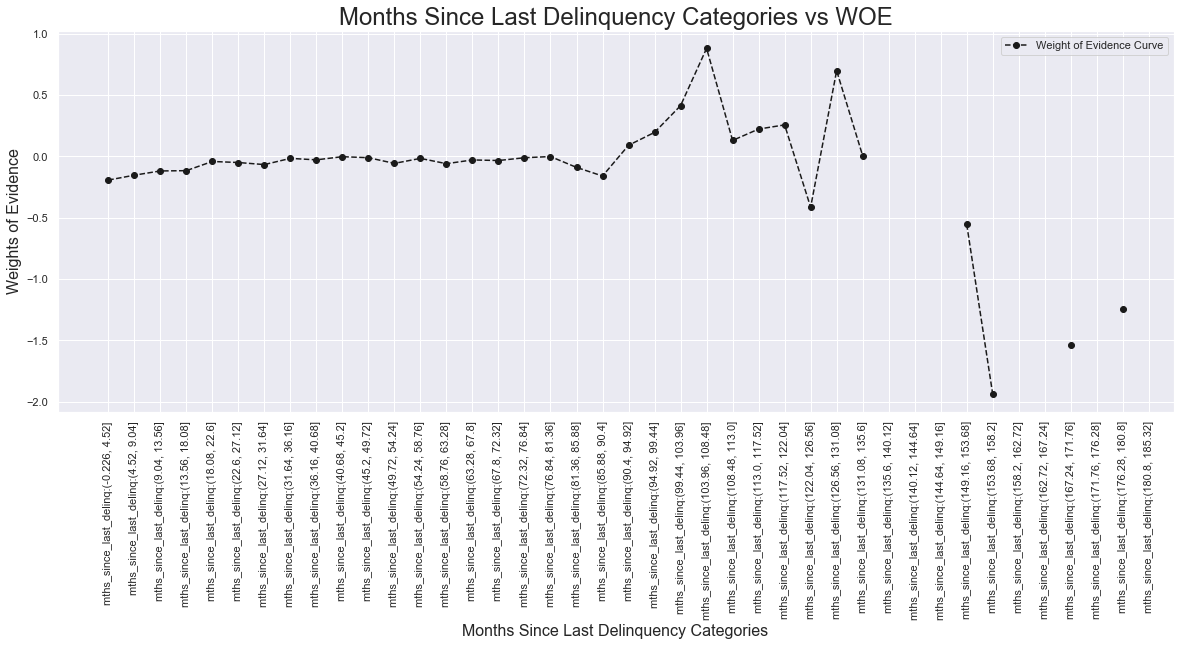

,n_obs,proba_n_obs,pos_obs,proba_pos_obs,neg_obs,proba_neg_obs,woe,woe_diff,iv
"mths_since_last_delinq:(-0.226, 4.52]",38526,0.0213023,32808,0.0207481,5718,0.0251585,-0.192742,NaN,NaN
"mths_since_last_delinq:(4.52, 9.04]",78567,0.0434424,67298,0.0425599,11269,0.0495822,-0.152721,0.0400216,NaN
"mths_since_last_delinq:(9.04, 13.56]",63832,0.0352949,54944,0.0347471,8888,0.0391061,-0.118183,0.0345375,NaN
"mths_since_last_delinq:(13.56, 18.08]",76724,0.0424233,66063,0.0417788,10661,0.0469071,-0.115779,0.00240418,NaN
"mths_since_last_delinq:(18.08, 22.6]",59176,0.0327204,51470,0.0325501,7706,0.0339055,-0.0407959,0.0749833,NaN
"mths_since_last_delinq:(22.6, 27.12]",71670,0.0396288,62267,0.0393782,9403,0.0413721,-0.049393,-0.00859706,NaN
"mths_since_last_delinq:(27.12, 31.64]",54412,0.0300862,47168,0.0298295,7244,0.0318727,-0.0662536,-0.0168606,NaN
"mths_since_last_delinq:(31.64, 36.16]",64033,0.035406,55875,0.0353359,8158,0.0358942,-0.0156778,0.0505759,NaN
"mths_since_last_delinq:(36.16, 40.68]",48441,0.0267847,42205,0.0266908,6236,0.0274376,-0.027596,-0.0119183,NaN
"mths_since_last_delinq:(40.68, 45.2]",58392,0.0322869,51042,0.0322794,7350,0.0323391,-0.00184727,0.0257488,NaN


In [181]:
calc_woe_df(mths_since_last_delinq_df_dummies_train, train_targets, 'Months Since Last Delinquency', 90)

#### Removing Categories that give Null/Inf/NaN as WoE

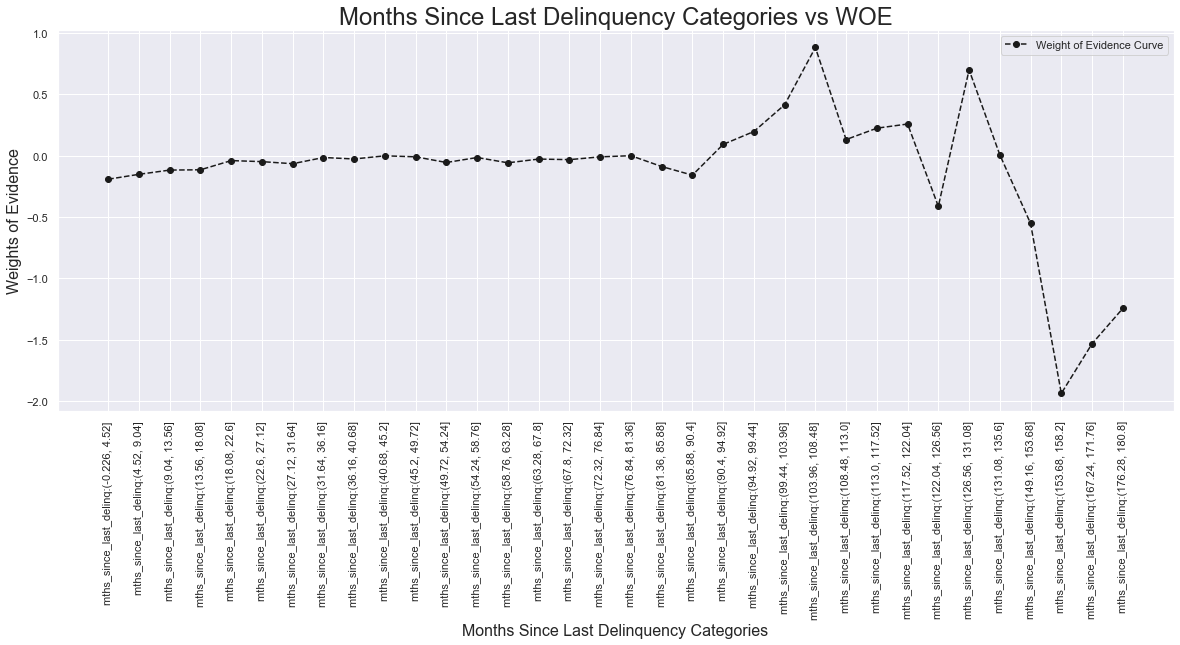

,n_obs,proba_n_obs,pos_obs,proba_pos_obs,neg_obs,proba_neg_obs,woe,woe_diff,iv
"mths_since_last_delinq:(-0.226, 4.52]",38526,0.0213023,32808,0.0207481,5718,0.0251585,-0.192742,NaN,0.003677
"mths_since_last_delinq:(4.52, 9.04]",78567,0.0434424,67298,0.0425599,11269,0.0495822,-0.152721,0.0400216,0.003677
"mths_since_last_delinq:(9.04, 13.56]",63832,0.0352949,54944,0.0347471,8888,0.0391061,-0.118183,0.0345375,0.003677
"mths_since_last_delinq:(13.56, 18.08]",76724,0.0424233,66063,0.0417788,10661,0.0469071,-0.115779,0.00240418,0.003677
"mths_since_last_delinq:(18.08, 22.6]",59176,0.0327204,51470,0.0325501,7706,0.0339055,-0.0407959,0.0749833,0.003677
"mths_since_last_delinq:(22.6, 27.12]",71670,0.0396288,62267,0.0393782,9403,0.0413721,-0.049393,-0.00859706,0.003677
"mths_since_last_delinq:(27.12, 31.64]",54412,0.0300862,47168,0.0298295,7244,0.0318727,-0.0662536,-0.0168606,0.003677
"mths_since_last_delinq:(31.64, 36.16]",64033,0.035406,55875,0.0353359,8158,0.0358942,-0.0156778,0.0505759,0.003677
"mths_since_last_delinq:(36.16, 40.68]",48441,0.0267847,42205,0.0266908,6236,0.0274376,-0.027596,-0.0119183,0.003677
"mths_since_last_delinq:(40.68, 45.2]",58392,0.0322869,51042,0.0322794,7350,0.0323391,-0.00184727,0.0257488,0.003677


In [182]:
to_remove  = [
    'mths_since_last_delinq:(135.6, 140.12]',
    'mths_since_last_delinq:(140.12, 144.64]',
    'mths_since_last_delinq:(144.64, 149.16]',
    'mths_since_last_delinq:(158.2, 162.72]',
    'mths_since_last_delinq:(162.72, 167.24]',
    'mths_since_last_delinq:(171.76, 176.28]',
    'mths_since_last_delinq:(180.8, 185.32]',
    'mths_since_last_delinq:(185.32, 189.84]',
    'mths_since_last_delinq:(189.84, 194.36]',
    'mths_since_last_delinq:(194.36, 198.88]',
    'mths_since_last_delinq:(198.88, 203.4]',
    'mths_since_last_delinq:(203.4, 207.92]',
    'mths_since_last_delinq:(207.92, 212.44]',
    'mths_since_last_delinq:(212.44, 216.96]',
    'mths_since_last_delinq:(216.96, 221.48]',
    'mths_since_last_delinq:(221.48, 226.0]'
]
calc_woe_df(mths_since_last_delinq_df_dummies_train.drop(to_remove, axis=1), train_targets, 'Months Since Last Delinquency', 90)

#### Training Features of mths_since_last_delinq column

In [183]:
mths_since_last_delinq_training_features_df = pd.DataFrame(columns = [
    'mths_since_last_delinq:0_20',
    'mths_since_last_delinq:20_60',
    'mths_since_last_delinq:60_80',
    'mths_since_last_delinq:80+',
], index=train_indices)

mths_since_last_delinq_training_features_df['mths_since_last_delinq:0_20'] = np.where(((mths_since_last_delinq_df_train['mths_since_last_delinq'] >= 0) & (mths_since_last_delinq_df_train['mths_since_last_delinq'] < 0)), 1, 0)
mths_since_last_delinq_training_features_df['mths_since_last_delinq:20_60'] = np.where(((mths_since_last_delinq_df_train['mths_since_last_delinq'] >= 20) & (mths_since_last_delinq_df_train['mths_since_last_delinq'] < 60)), 1, 0)
mths_since_last_delinq_training_features_df['mths_since_last_delinq:60_80'] = np.where(((mths_since_last_delinq_df_train['mths_since_last_delinq'] >= 60) & (mths_since_last_delinq_df_train['mths_since_last_delinq'] < 80)), 1, 0)
mths_since_last_delinq_training_features_df['mths_since_last_delinq:80+'] = np.where(mths_since_last_delinq_df_train['mths_since_last_delinq'] > 80, 1, 0)

#### Testing Features of mths_since_last_delinq column

In [184]:
mths_since_last_delinq_testing_features_df = pd.DataFrame(columns = [
    'mths_since_last_delinq:0_20',
    'mths_since_last_delinq:20_60',
    'mths_since_last_delinq:60_80',
    'mths_since_last_delinq:80+',
], index=test_indices)

mths_since_last_delinq_testing_features_df['mths_since_last_delinq:0_20'] = np.where(((mths_since_last_delinq_df_test['mths_since_last_delinq'] >= 0) & (mths_since_last_delinq_df_test['mths_since_last_delinq'] < 0)), 1, 0)
mths_since_last_delinq_testing_features_df['mths_since_last_delinq:20_60'] = np.where(((mths_since_last_delinq_df_test['mths_since_last_delinq'] >= 20) & (mths_since_last_delinq_df_test['mths_since_last_delinq'] < 60)), 1, 0)
mths_since_last_delinq_testing_features_df['mths_since_last_delinq:60_80'] = np.where(((mths_since_last_delinq_df_test['mths_since_last_delinq'] >= 60) & (mths_since_last_delinq_df_test['mths_since_last_delinq'] < 80)), 1, 0)
mths_since_last_delinq_testing_features_df['mths_since_last_delinq:80+'] = np.where(mths_since_last_delinq_df_test['mths_since_last_delinq'] > 80, 1, 0)

#### Adding mths_since_last_delinq feature to the set of training and testing features

In [185]:
training_features_df = pd.concat((training_features_df, mths_since_last_delinq_training_features_df), axis=1)
testing_features_df = pd.concat((testing_features_df, mths_since_last_delinq_testing_features_df), axis=1)

#### Updating Backups

In [186]:
training_features_df_continuous = training_features_df.copy()
testing_features_df_continuous = testing_features_df.copy()

## Months since last Record

In [187]:
mths_since_last_record_df_backup = pd.read_csv('Columns/mths_since_last_record.csv')
mths_since_last_record_df = mths_since_last_record_df_backup[['mths_since_last_record']]
# mths_since_last_record_df['mths_since_last_record'] = mths_since_last_record_df['mths_since_last_record'].fillna(0)
# mths_since_last_record_df['mths_since_last_record'] = mths_since_last_record_df['mths_since_last_record'].astype('int64')

#### Range of  Values

In [188]:
mths_since_last_record_df['mths_since_last_record'].unique()

array([ 45.,  75.,  nan, 100., 107.,  67., 106.,  60.,  92.,  62.,  34.,
        11.,  63.,  84., 104., 118.,  93.,  88.,  29.,  43.,  61.,  86.,
        66., 103., 112., 114.,  58.,  99.,  90.,  87., 117.,  96.,  53.,
        98.,  85.,  68.,  94.,  51., 105.,  81., 113., 108.,  91.,  77.,
        48., 115.,  71.,  79.,  56.,  19.,  83.,  42.,  97.,  95.,  70.,
        73., 111.,  74.,  76., 102.,  89., 101.,  41.,  80.,  78.,  52.,
        46., 109.,  55.,  50.,  69., 110.,  72.,  30.,  64.,  39.,  57.,
        82., 116., 119.,  40.,  38.,  65.,  26.,  23.,  16.,  59.,  31.,
        21.,  35.,  49.,  36.,  54.,  22.,  28.,  33.,  44.,  47.,  13.,
        24.,  20.,   6.,  32.,  18.,  37.,  27.,  15.,   8.,  25.,  10.,
         7.,  14.,  17.,   5.,   9.,  12., 127., 120., 124., 121., 126.,
       123., 122.,   4., 125.,   1.,   3.,   2.,   0., 129.])

In [189]:
mths_since_last_record_df['mths_since_last_record'].describe()

count    359156.000000
mean         72.312842
std          26.464094
min           0.000000
25%          55.000000
50%          74.000000
75%          92.000000
max         129.000000
Name: mths_since_last_record, dtype: float64

#### Missing Values

In [190]:
mths_since_last_record_df['mths_since_last_record'].isna().sum()

1901512

#### mths_since_last_record Column train test split

In [191]:
mths_since_last_record_df_train, mths_since_last_record_df_test = mths_since_last_record_df.iloc[train_indices], mths_since_last_record_df.iloc[test_indices]

#### Fine Classing mths_since_last_record into Categories and creating dummies

In [192]:
mths_since_last_record_df_dummies = pd.get_dummies(pd.cut(mths_since_last_record_df['mths_since_last_record'], 50), prefix='mths_since_last_record', prefix_sep=':')

#### mths_since_last_record dummies Column train test split

In [193]:
mths_since_last_record_df_dummies_train, mths_since_last_record_df_dummies_test = mths_since_last_record_df_dummies.iloc[train_indices], mths_since_last_record_df_dummies.iloc[test_indices]

#### mths_since_last_record column WOE dataframe and plot

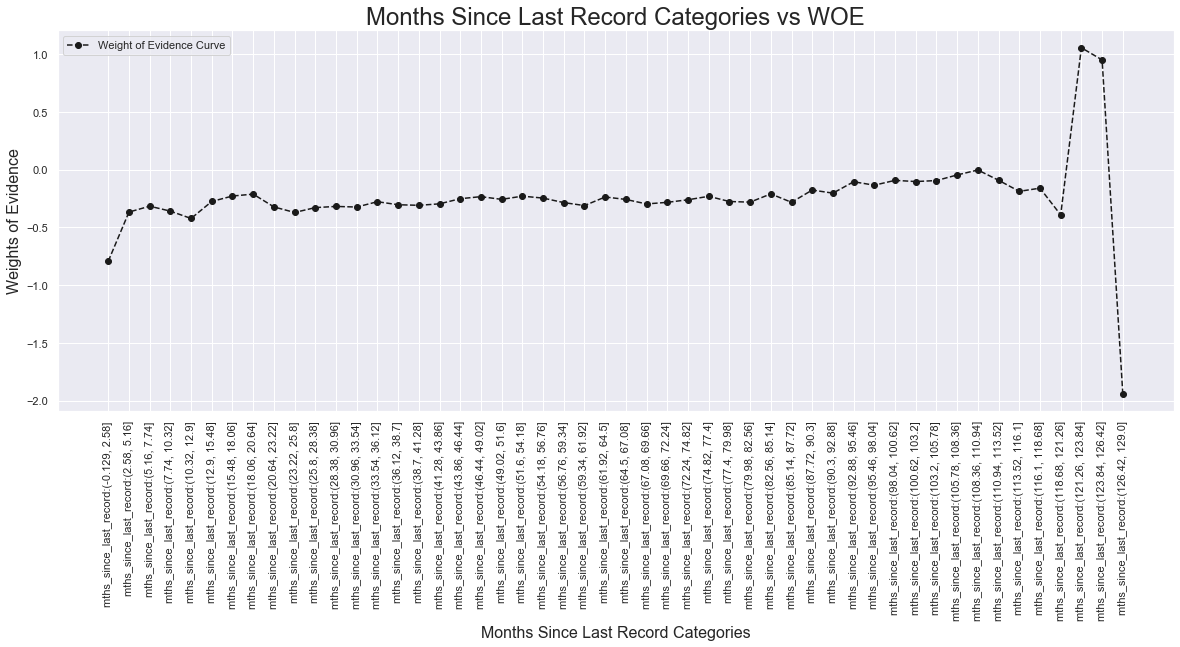

,n_obs,proba_n_obs,pos_obs,proba_pos_obs,neg_obs,proba_neg_obs,woe,woe_diff,iv
"mths_since_last_record:(-0.129, 2.58]",1315,0.000727108,998,0.000631144,317,0.00139476,-0.792944,NaN,0.010537
"mths_since_last_record:(2.58, 5.16]",902,0.000498746,747,0.00047241,155,0.000681981,-0.367156,0.425789,0.010537
"mths_since_last_record:(5.16, 7.74]",844,0.000466676,705,0.000445848,139,0.000611583,-0.316072,0.0510838,0.010537
"mths_since_last_record:(7.74, 10.32]",1576,0.000871424,1307,0.000826559,269,0.00118357,-0.359017,-0.0429455,0.010537
"mths_since_last_record:(10.32, 12.9]",1201,0.000664074,985,0.000622923,216,0.000950374,-0.422433,-0.0634151,0.010537
"mths_since_last_record:(12.9, 15.48]",1879,0.00103896,1580,0.000999206,299,0.00131556,-0.275059,0.147373,0.010537
"mths_since_last_record:(15.48, 18.06]",1994,0.00110255,1689,0.00106814,305,0.00134196,-0.228216,0.0468436,0.010537
"mths_since_last_record:(18.06, 20.64]",1525,0.000843224,1295,0.00081897,230,0.00101197,-0.211609,0.0166065,0.010537
"mths_since_last_record:(20.64, 23.22]",2440,0.00134916,2036,0.00128758,404,0.00177755,-0.322468,-0.110859,0.010537
"mths_since_last_record:(23.22, 25.8]",1886,0.00104283,1561,0.000987191,325,0.00142996,-0.370539,-0.0480708,0.010537


In [194]:
calc_woe_df(mths_since_last_record_df_dummies_train, train_targets, 'Months Since Last Record', 90)

#### Training Features of mths_since_last_record column

In [195]:
mths_since_last_record_training_features_df = pd.DataFrame(columns = [
    'mths_since_last_record:0_24',
    'mths_since_last_record:24_60',
    'mths_since_last_record:60+'
], index=train_indices)

mths_since_last_record_training_features_df['mths_since_last_record:0_24'] = np.where(((mths_since_last_record_df_train['mths_since_last_record'] >= 0) & (mths_since_last_record_df_train['mths_since_last_record'] < 24)), 1, 0)
mths_since_last_record_training_features_df['mths_since_last_record:24_60'] = np.where(((mths_since_last_record_df_train['mths_since_last_record'] >= 24) & (mths_since_last_record_df_train['mths_since_last_record'] < 60)), 1, 0)
mths_since_last_record_training_features_df['mths_since_last_record:60+'] = np.where(mths_since_last_record_df_train['mths_since_last_record'] > 60, 1, 0)

#### Testing Features of mths_since_last_record column

In [196]:
mths_since_last_record_testing_features_df = pd.DataFrame(columns = [
    'mths_since_last_record:0_24',
    'mths_since_last_record:24_60',
    'mths_since_last_record:60+'
], index=test_indices)

mths_since_last_record_testing_features_df['mths_since_last_record:0_24'] = np.where(((mths_since_last_record_df_test['mths_since_last_record'] >= 0) & (mths_since_last_record_df_test['mths_since_last_record'] < 24)), 1, 0)
mths_since_last_record_testing_features_df['mths_since_last_record:24_60'] = np.where(((mths_since_last_record_df_test['mths_since_last_record'] >= 24) & (mths_since_last_record_df_test['mths_since_last_record'] < 60)), 1, 0)
mths_since_last_record_testing_features_df['mths_since_last_record:60+'] = np.where(mths_since_last_record_df_test['mths_since_last_record'] > 60, 1, 0)

#### Adding mths_since_last_record feature to the set of training and testing features

In [197]:
training_features_df = pd.concat((training_features_df, mths_since_last_record_training_features_df), axis=1)
testing_features_df = pd.concat((testing_features_df, mths_since_last_record_testing_features_df), axis=1)

#### Updating Backups

In [198]:
training_features_df_continuous = training_features_df.copy()
testing_features_df_continuous = testing_features_df.copy()

## DTI - Debt to Income Ratio

In [199]:
dti_df_backup = pd.read_csv('Columns/dti.csv')
dti_df = dti_df_backup[['dti']]
# dti_df['dti'] = dti_df['dti'].fillna(0)
# dti_df['dti'] = dti_df['dti'].astype('int64')

#### Range of  Values

In [200]:
dti_df['dti'].describe()

count    2.258957e+06
mean     1.882420e+01
std      1.418333e+01
min     -1.000000e+00
25%      1.189000e+01
50%      1.784000e+01
75%      2.449000e+01
max      9.990000e+02
Name: dti, dtype: float64

#### Missing Values

In [201]:
dti_df['dti'].isna().sum()

1711

#### dti Column train test split

In [202]:
dti_df_train, dti_df_test = dti_df.iloc[train_indices], dti_df.iloc[test_indices]

#### Distribution of DTI

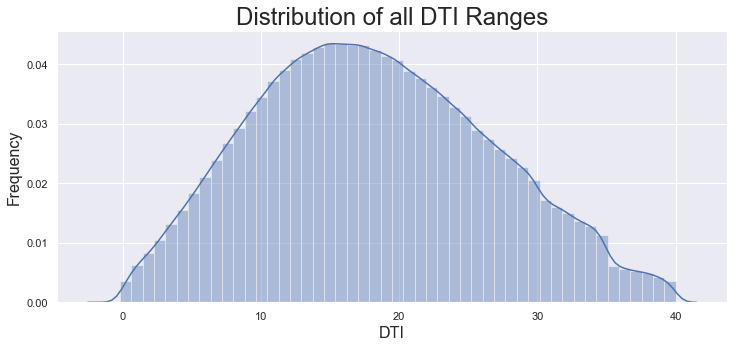

In [203]:
plt.figure(figsize = (12, 5))

sns.distplot(dti_df_train[dti_df_train['dti'] < 40].dropna())

plt.title('Distribution of all DTI Ranges', size=24)
plt.xlabel('DTI', size=16)
plt.ylabel('Frequency', size=16)

plt.show()

#### Fine Classing dti into Categories and creating dummies

In [204]:
dti_df_dummies = pd.DataFrame(columns=[
    'dti:0_4',
    'dti:4_8',
    'dti:8_12',
    'dti:12_16',
    'dti:16_20',
    'dti:20_24',
    'dti:24_28',
    'dti:28_32',
    'dti:32_36',
    'dti:36_40',
    'dti:40+'
])

dti_df_dummies['dti:0_4'] = np.where(dti_df['dti'] < 4, 1, 0)
dti_df_dummies['dti:4_8'] = np.where(((dti_df['dti'] >= 4) & (dti_df['dti'] < 8)), 1, 0)
dti_df_dummies['dti:8_12'] = np.where(((dti_df['dti'] >= 8) & (dti_df['dti'] < 12)), 1, 0)
dti_df_dummies['dti:12_16'] = np.where(((dti_df['dti'] >= 12) & (dti_df['dti'] < 16)), 1, 0)
dti_df_dummies['dti:16_20'] = np.where(((dti_df['dti'] >= 16) & (dti_df['dti'] < 20)), 1, 0)
dti_df_dummies['dti:20_24'] = np.where(((dti_df['dti'] >= 20) & (dti_df['dti'] < 24)), 1, 0)
dti_df_dummies['dti:24_28'] = np.where(((dti_df['dti'] >= 24) & (dti_df['dti'] < 28)), 1, 0)
dti_df_dummies['dti:28_32'] = np.where(((dti_df['dti'] >= 28) & (dti_df['dti'] < 32)), 1, 0)
dti_df_dummies['dti:32_36'] = np.where(((dti_df['dti'] >= 32) & (dti_df['dti'] < 36)), 1, 0)
dti_df_dummies['dti:36_40'] = np.where(((dti_df['dti'] >= 36) & (dti_df['dti'] < 40)), 1, 0)
dti_df_dummies['dti:40+'] = np.where(dti_df['dti'] >= 40, 1, 0)

#### dti dummies Column train test split

In [205]:
dti_df_dummies_train, dti_df_dummies_test = dti_df_dummies.loc[train_indices], dti_df_dummies.loc[test_indices]

#### dti column WOE dataframe and plot

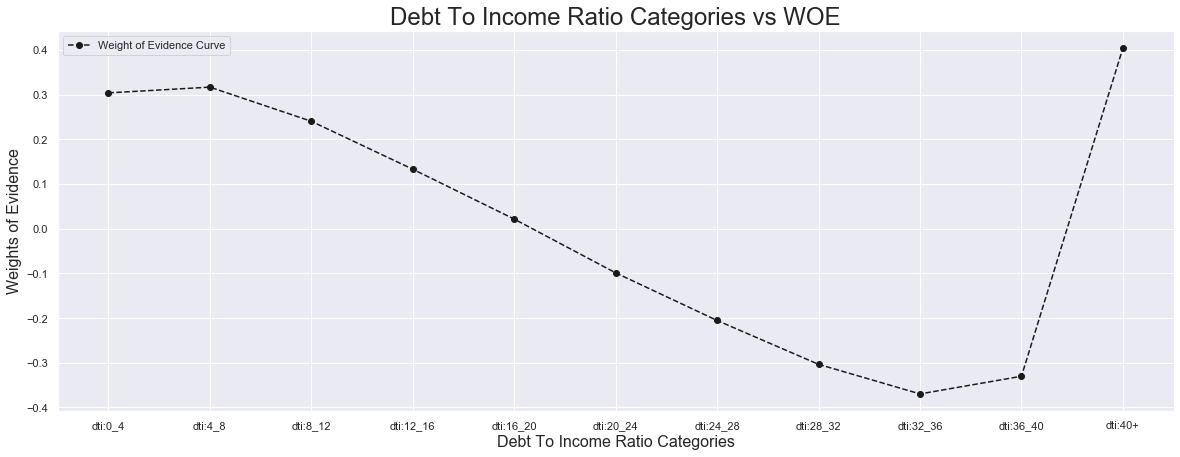

,n_obs,proba_n_obs,pos_obs,proba_pos_obs,neg_obs,proba_neg_obs,woe,woe_diff,iv
dti:0_4,63326,0.0350151,57253,0.0362073,6073,0.0267205,0.303832,NaN,0.045971
dti:4_8,151630,0.0838414,137257,0.0868026,14373,0.0632395,0.316708,0.0128763,0.045971
dti:8_12,244290,0.135076,219482,0.138802,24808,0.109152,0.240308,-0.0763996,0.045971
dti:12_16,302630,0.167334,268806,0.169995,33824,0.148821,0.133024,-0.107285,0.045971
dti:16_20,302967,0.167521,265602,0.167969,37365,0.164401,0.0214687,-0.111555,0.045971
dti:20_24,261876,0.1448,226015,0.142934,35861,0.157784,-0.0988448,-0.120313,0.045971
dti:24_28,203749,0.11266,173181,0.109521,30568,0.134495,-0.205412,-0.106567,0.045971
dti:28_32,139702,0.077246,116934,0.0739501,22768,0.100176,-0.303542,-0.0981299,0.045971
dti:32_36,81818,0.04524,67728,0.0428318,14090,0.0619943,-0.369761,-0.0662193,0.045971
dti:36_40,33526,0.0185377,27939,0.0176689,5587,0.0245821,-0.330215,0.0395467,0.045971


In [206]:
calc_woe_df(dti_df_dummies_train, train_targets, 'Debt To Income Ratio', 0)

#### Training Features of dti column

In [207]:
dti_training_features_df = pd.DataFrame(columns = [
    'dti:0_4',
    'dti:4_8',
    'dti:8_12',
    'dti:12_16',
    'dti:16_20',
    'dti:20_24',
    'dti:24_28',
    'dti:28_32',
    'dti:32_36',
    'dti:36_40',
    'dti:40+'
], index=train_indices)

dti_training_features_df['dti:0_4'] = np.where(dti_df_train['dti'] < 4, 1, 0)
dti_training_features_df['dti:4_8'] = np.where(((dti_df_train['dti'] >= 4) & (dti_df_train['dti'] < 8)), 1, 0)
dti_training_features_df['dti:8_12'] = np.where(((dti_df_train['dti'] >= 8) & (dti_df_train['dti'] < 12)), 1, 0)
dti_training_features_df['dti:12_16'] = np.where(((dti_df_train['dti'] >= 12) & (dti_df_train['dti'] < 16)), 1, 0)
dti_training_features_df['dti:16_20'] = np.where(((dti_df_train['dti'] >= 16) & (dti_df_train['dti'] < 20)), 1, 0)
dti_training_features_df['dti:20_24'] = np.where(((dti_df_train['dti'] >= 20) & (dti_df_train['dti'] < 24)), 1, 0)
dti_training_features_df['dti:24_28'] = np.where(((dti_df_train['dti'] >= 24) & (dti_df_train['dti'] < 28)), 1, 0)
dti_training_features_df['dti:28_32'] = np.where(((dti_df_train['dti'] >= 28) & (dti_df_train['dti'] < 32)), 1, 0)
dti_training_features_df['dti:32_36'] = np.where(((dti_df_train['dti'] >= 32) & (dti_df_train['dti'] < 36)), 1, 0)
dti_training_features_df['dti:36_40'] = np.where(((dti_df_train['dti'] >= 36) & (dti_df_train['dti'] < 40)), 1, 0)
dti_training_features_df['dti:40+'] = np.where(dti_df_train['dti'] >= 40, 1, 0)

#### Testing Features of dti column

In [208]:
dti_testing_features_df = pd.DataFrame(columns = [
    'dti:0_4',
    'dti:4_8',
    'dti:8_12',
    'dti:12_16',
    'dti:16_20',
    'dti:20_24',
    'dti:24_28',
    'dti:28_32',
    'dti:32_36',
    'dti:36_40',
    'dti:40+'
], index=test_indices)

dti_testing_features_df['dti:0_4'] = np.where(dti_df_test['dti'] < 4, 1, 0)
dti_testing_features_df['dti:4_8'] = np.where(((dti_df_test['dti'] >= 4) & (dti_df_test['dti'] < 8)), 1, 0)
dti_testing_features_df['dti:8_12'] = np.where(((dti_df_test['dti'] >= 8) & (dti_df_test['dti'] < 12)), 1, 0)
dti_testing_features_df['dti:12_16'] = np.where(((dti_df_test['dti'] >= 12) & (dti_df_test['dti'] < 16)), 1, 0)
dti_testing_features_df['dti:16_20'] = np.where(((dti_df_test['dti'] >= 16) & (dti_df_test['dti'] < 20)), 1, 0)
dti_testing_features_df['dti:20_24'] = np.where(((dti_df_test['dti'] >= 20) & (dti_df_test['dti'] < 24)), 1, 0)
dti_testing_features_df['dti:24_28'] = np.where(((dti_df_test['dti'] >= 24) & (dti_df_test['dti'] < 28)), 1, 0)
dti_testing_features_df['dti:28_32'] = np.where(((dti_df_test['dti'] >= 28) & (dti_df_test['dti'] < 32)), 1, 0)
dti_testing_features_df['dti:32_36'] = np.where(((dti_df_test['dti'] >= 32) & (dti_df_test['dti'] < 36)), 1, 0)
dti_testing_features_df['dti:36_40'] = np.where(((dti_df_test['dti'] >= 36) & (dti_df_test['dti'] < 40)), 1, 0)
dti_testing_features_df['dti:40+'] = np.where(dti_df_test['dti'] >= 40, 1, 0)

#### Adding dti feature to the set of training and testing features

In [209]:
training_features_df = pd.concat((training_features_df, dti_training_features_df), axis=1)
testing_features_df = pd.concat((testing_features_df, dti_testing_features_df), axis=1)

#### Updating Backups

In [210]:
training_features_df_continuous = training_features_df.copy()
testing_features_df_continuous = testing_features_df.copy()

In [212]:
training_features_df.head()

,term:60,term:36,emp_length:0,emp_length:1,emp_length:2_6,emp_length:7,emp_length:8,emp_length:9,emp_length:10,mths_issue_d:12_16,...,dti:4_8,dti:8_12,dti:12_16,dti:16_20,dti:20_24,dti:24_28,dti:28_32,dti:32_36,dti:36_40,dti:40+
305053,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
50247,1,0,1,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
1630001,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
927626,0,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
758488,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


In [213]:
testing_features_df.head()

,term:60,term:36,emp_length:0,emp_length:1,emp_length:2_6,emp_length:7,emp_length:8,emp_length:9,emp_length:10,mths_issue_d:12_16,...,dti:4_8,dti:8_12,dti:12_16,dti:16_20,dti:20_24,dti:24_28,dti:28_32,dti:32_36,dti:36_40,dti:40+
1758049,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
686533,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
900721,0,1,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1727912,1,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
539691,0,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


# Exporting CSV Files

In [ ]:
training_features_df.to_csv('training_features_df_continuous.csv', index=True)
testing_features_df.to_csv('testing_features_df_continuous.csv', index=True)

In [ ]:
training_features_df_continuous_imported_backup = pd.read_csv('training_features_df_continuous.csv')
testing_features_df_continuous_imported_backup = pd.read_csv('testing_features_df_continuous.csv')

In [ ]:
training_features_df = training_features_df_continuous_imported_backup.copy()
training_features_df = training_features_df.set_index('Unnamed: 0')

testing_features_df = testing_features_df_continuous_imported_backup.copy()
testing_features_df = testing_features_df.set_index('Unnamed: 0')

In [ ]:
training_features_df

In [ ]:
testing_features_df